In [ ]:
!pip install langchain_openai
!pip install langchain-community
!pip install pypdf
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.7
    Uninstalli

In [ ]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key 입력: ")

OpenAI API key 입력: ··········


# RAG 의 과정 훝어보기!


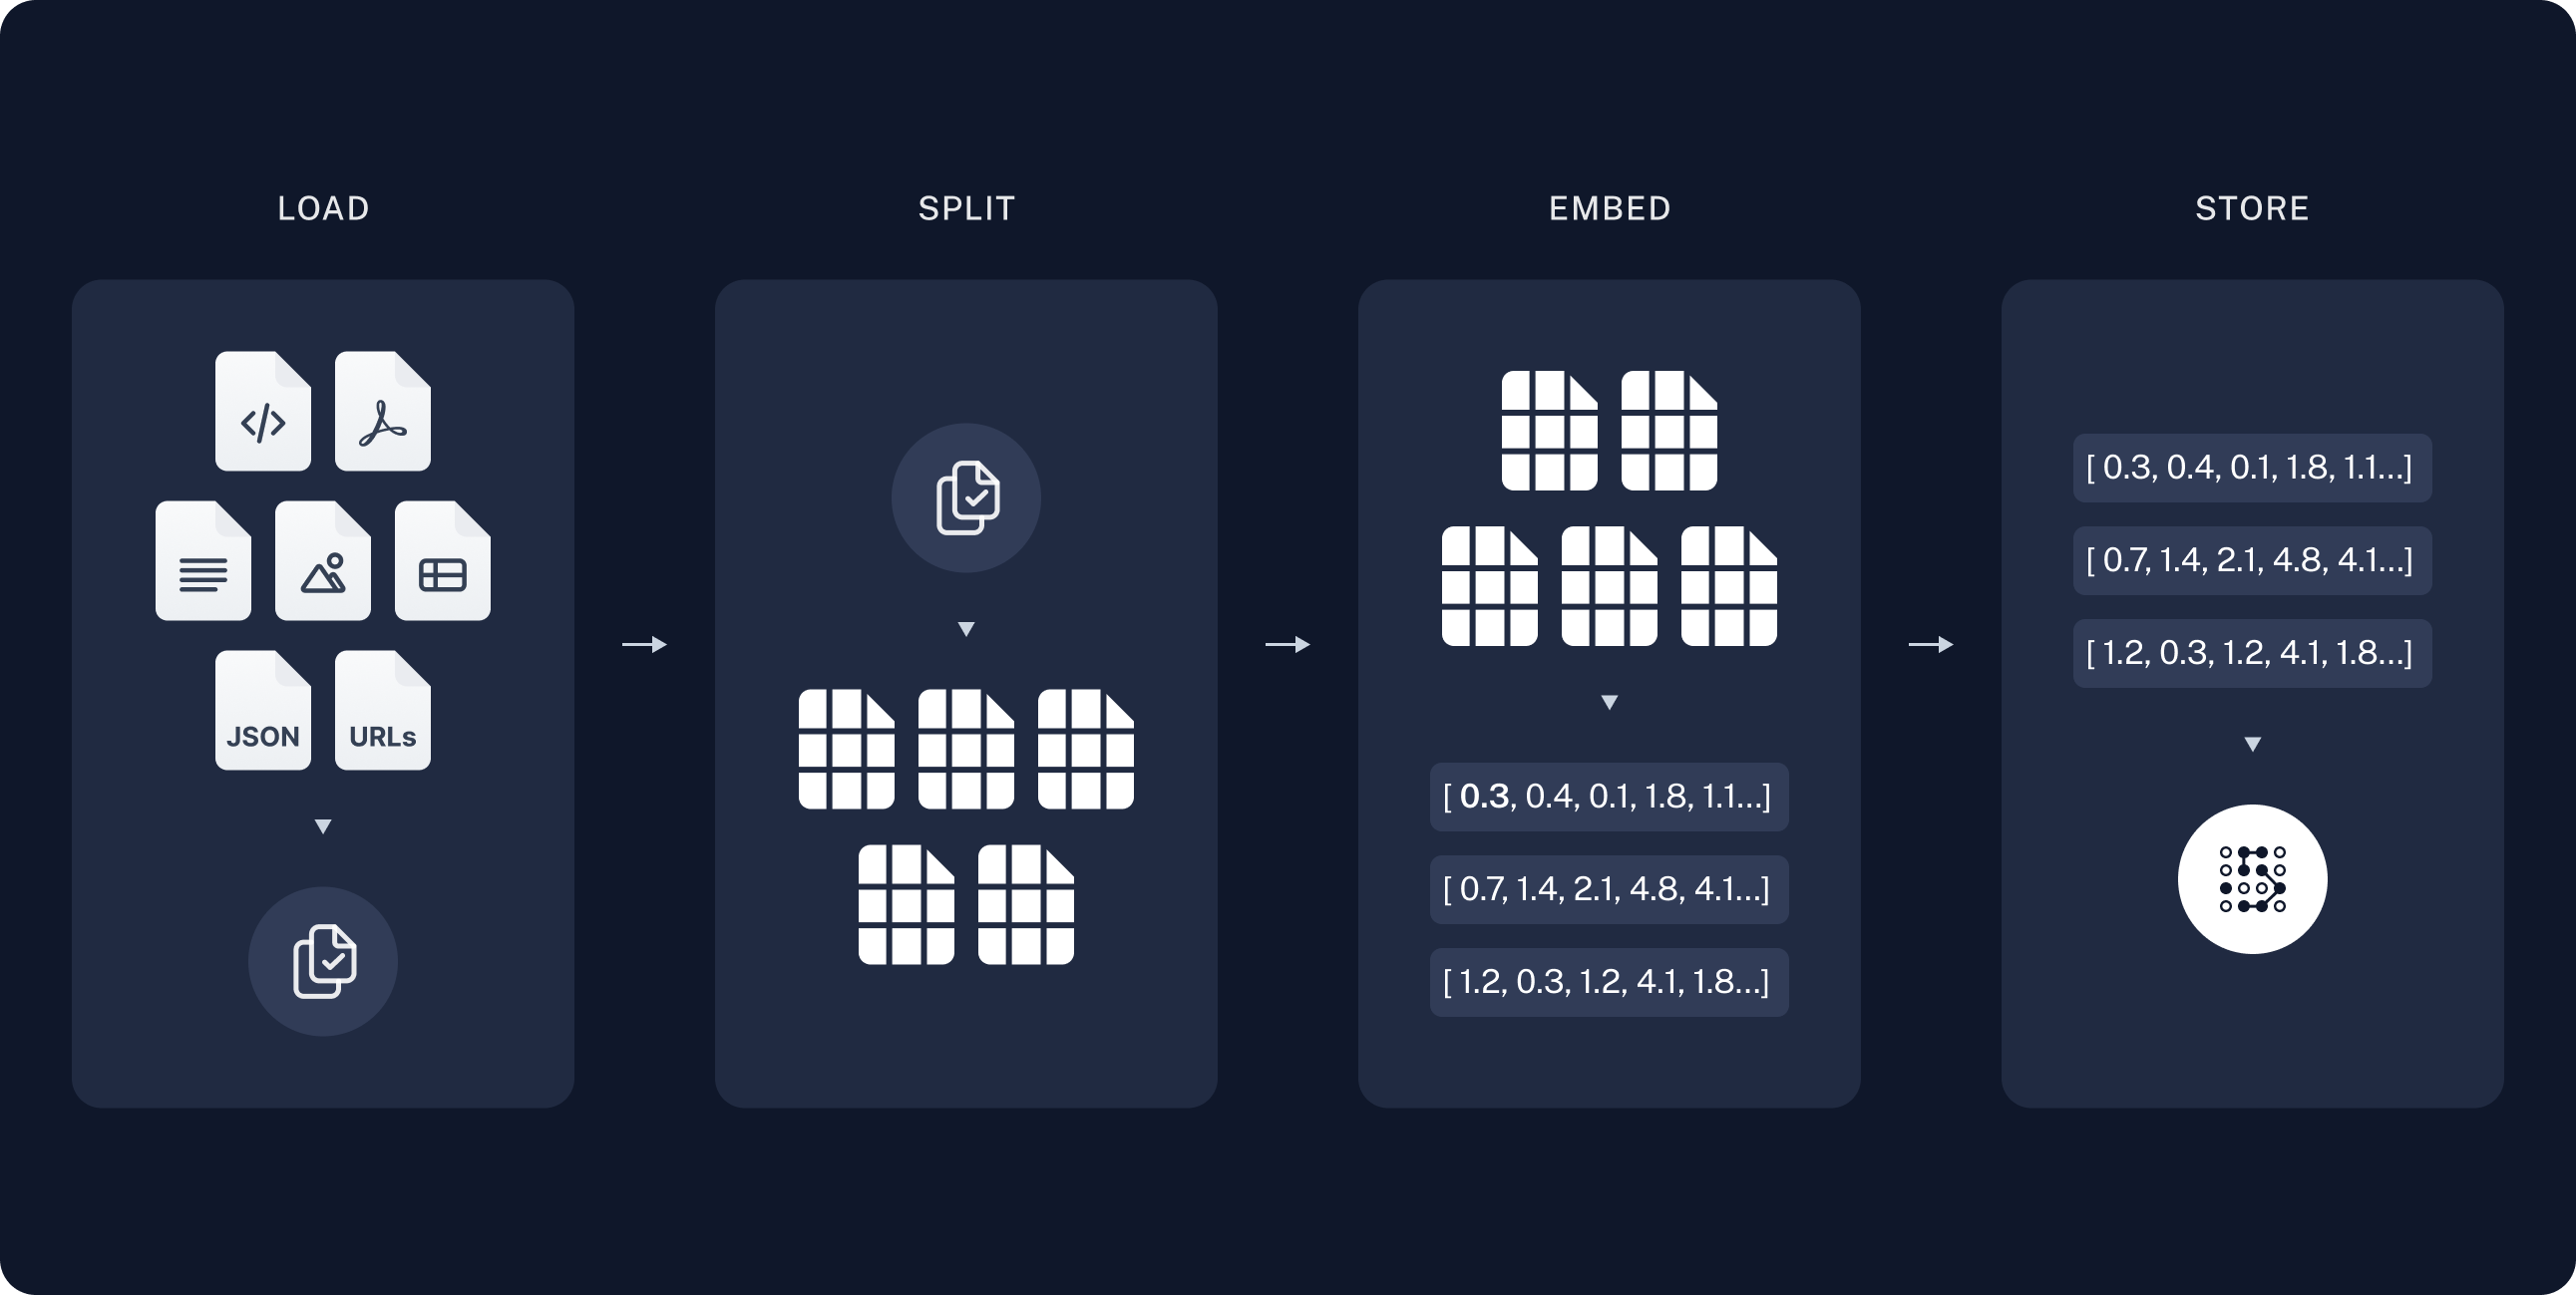

=========== RAG 구축 시작 !! ==============


1. 문서 로딩
  - 문서로는 JSON, 이미지, 텍스트, CSV, PDF 등 다양한 문서가 들어갈 수 있습니다.
2. 문서 chunking (spliting)
  - chunking은 긴 문서를 더 작고 관리하기 쉬운 부분들로 나누는 과정
  - vectorDB에 chunk단위로 적재하게 된다.
3. embedding
  - 문자열형태의 chunk를 벡터(숫자)로 변환하는 과정
4. 벡터 스토어
  - 이전 단계에서 생성된 임베딩 벡터들을 효율적으로 저장하고 관리하는 저장소


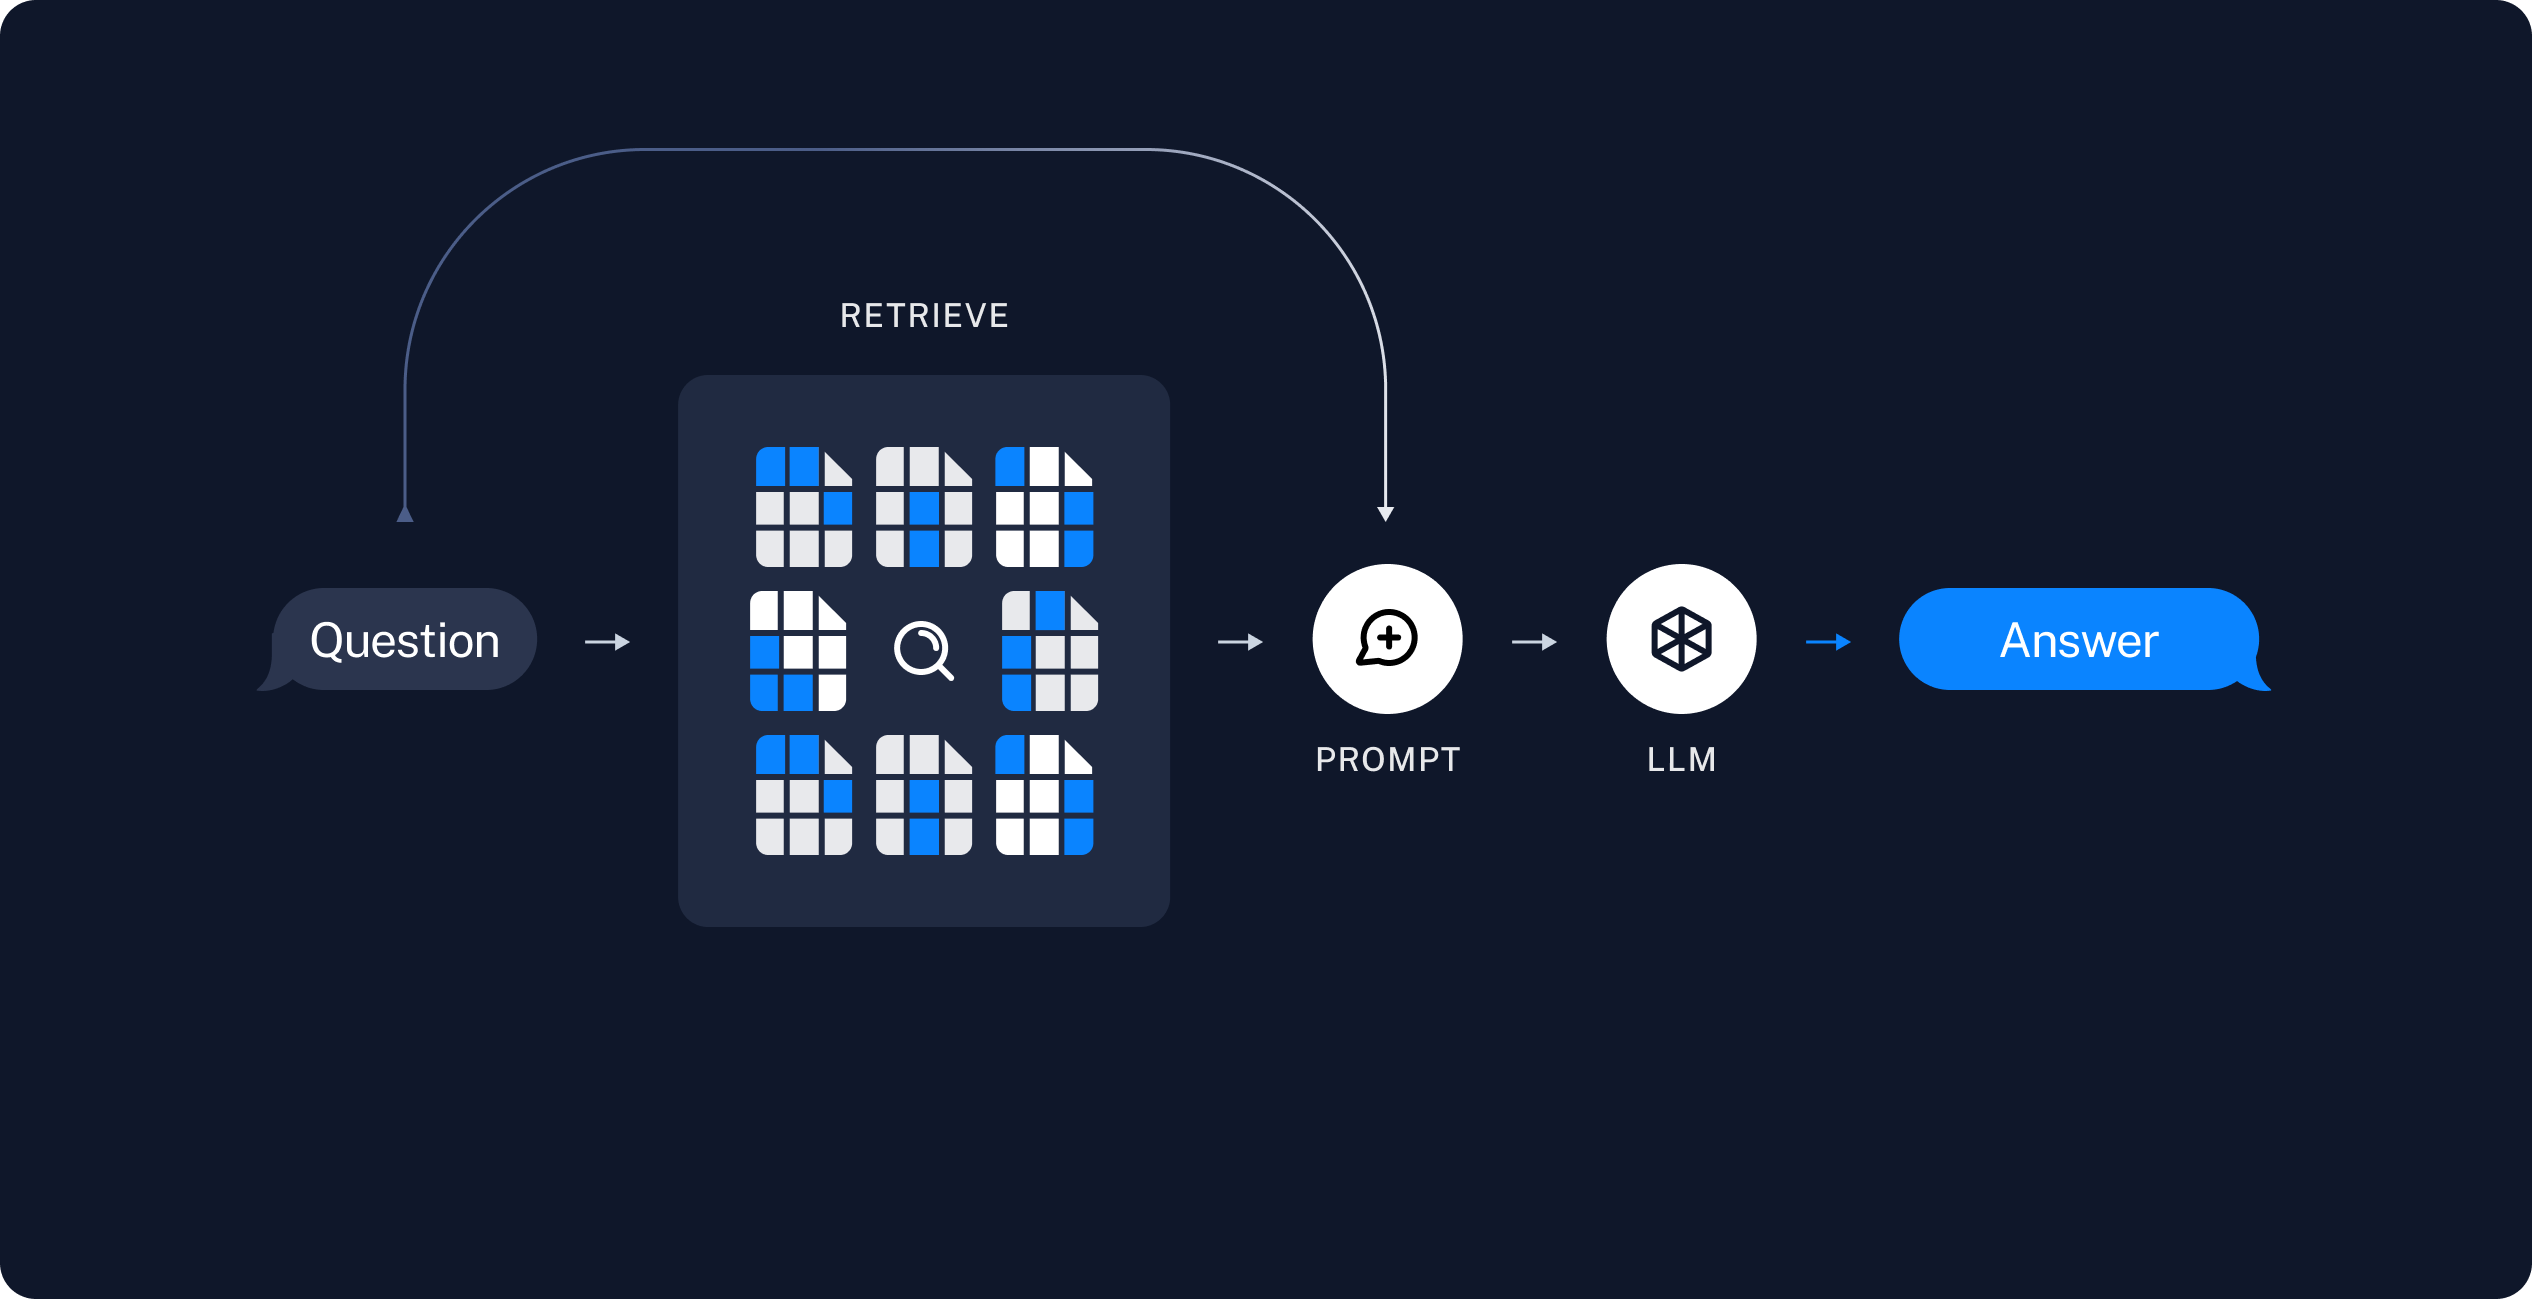

5. 리트리버 : 물어오기! 저장된 벡터 데이터베이스에서 사용자의 질문과 관련된 문서(context)를 검색(물어오기)하는 검색기


=========== RAG 구축 끝!! ==============

=========== 구축해둔 RAG 챗봇 구동 시작 ==========

1. 사용자가 질문하기 :
  - `사용자 : 우리 회사의 야근식대는 얼마야?`

2. Retrieval(검색) :
  - 리트리버가 사용자 질문에 대한 자료를 벡터 DB에서 검색해옴
  - 질문과 연관성이 높은 청크를 검색해서 context로 리턴한다.

3. Augment(증강) : 프롬프트 = context(벡터DB에서 검색해온 자료) + query(사용자 질문)
```
prompt = ChatPromptTemplate.from_template("""
오로지 아래의 context만을 기반으로 질문에 대답하세요:
{context}
질문:
{question}
""")
```
⬇️
```
prompt = ChatPromptTemplate.from_template("""
오로지 아래의 context만을 기반으로 질문에 대답하세요:
야근 식대는 2만원 입니다.
질문:
우리 회사의 야근 식대는 얼마입니까?
""")
```

4. Generation(생성) : LLM에 완성된 프롬프트 집어넣고 답변받기
  - 프롬프트에는 질문에 답변할 수 있는 자료(context, 맥락)이 있으니, LLM은 이를 기반으로 환각없이 잘 대답할 수 있다.
  - `무한상사 사규 챗봇: 우리회사의 야근식대는 2만원입니다.`






# RAG 과정 훝어보기


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import PyPDFLoader


####################
####### RAG 챗봇 구축
###################

# 1. LLM 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

# 2. 문서 불러오기
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf")
docs = loader.load()

# 3. 문서 chunking 하기
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# 4. 자른 chunk들을 embedding 하기
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# 5. vector store 구축하기
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)

# 6. retriever 구축하기
retriever = vectorstore.as_retriever()

# 7. 프롬프트 템플릿 구축하기
prompt = prompt = ChatPromptTemplate.from_template("""
오로지 아래의 context만을 기반으로 질문에 대답하세요:
{context}
질문:
{question}
""")


# 8. 1~7. 요소들을 chain으로 조합하여 RAG 구축 완료
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


####################
####### 구축한 RAG 챗봇 실행
###################

rag_chain.invoke("상장주식 대주주 기준이 50억 원 이상으로 완화되었는데 언제부터 적용되는 건가요?")

'상장주식 대주주 기준이 50억 원 이상으로 완화된 것은 2023년 말부터 적용됩니다. 그러나 이 기준은 2024년 1월 1일 이후 양도하는 주식에 대해 적용되며, 2024년 상반기 양도분에 대해서는 2024년 8월 예정신고부터 적용됩니다.'

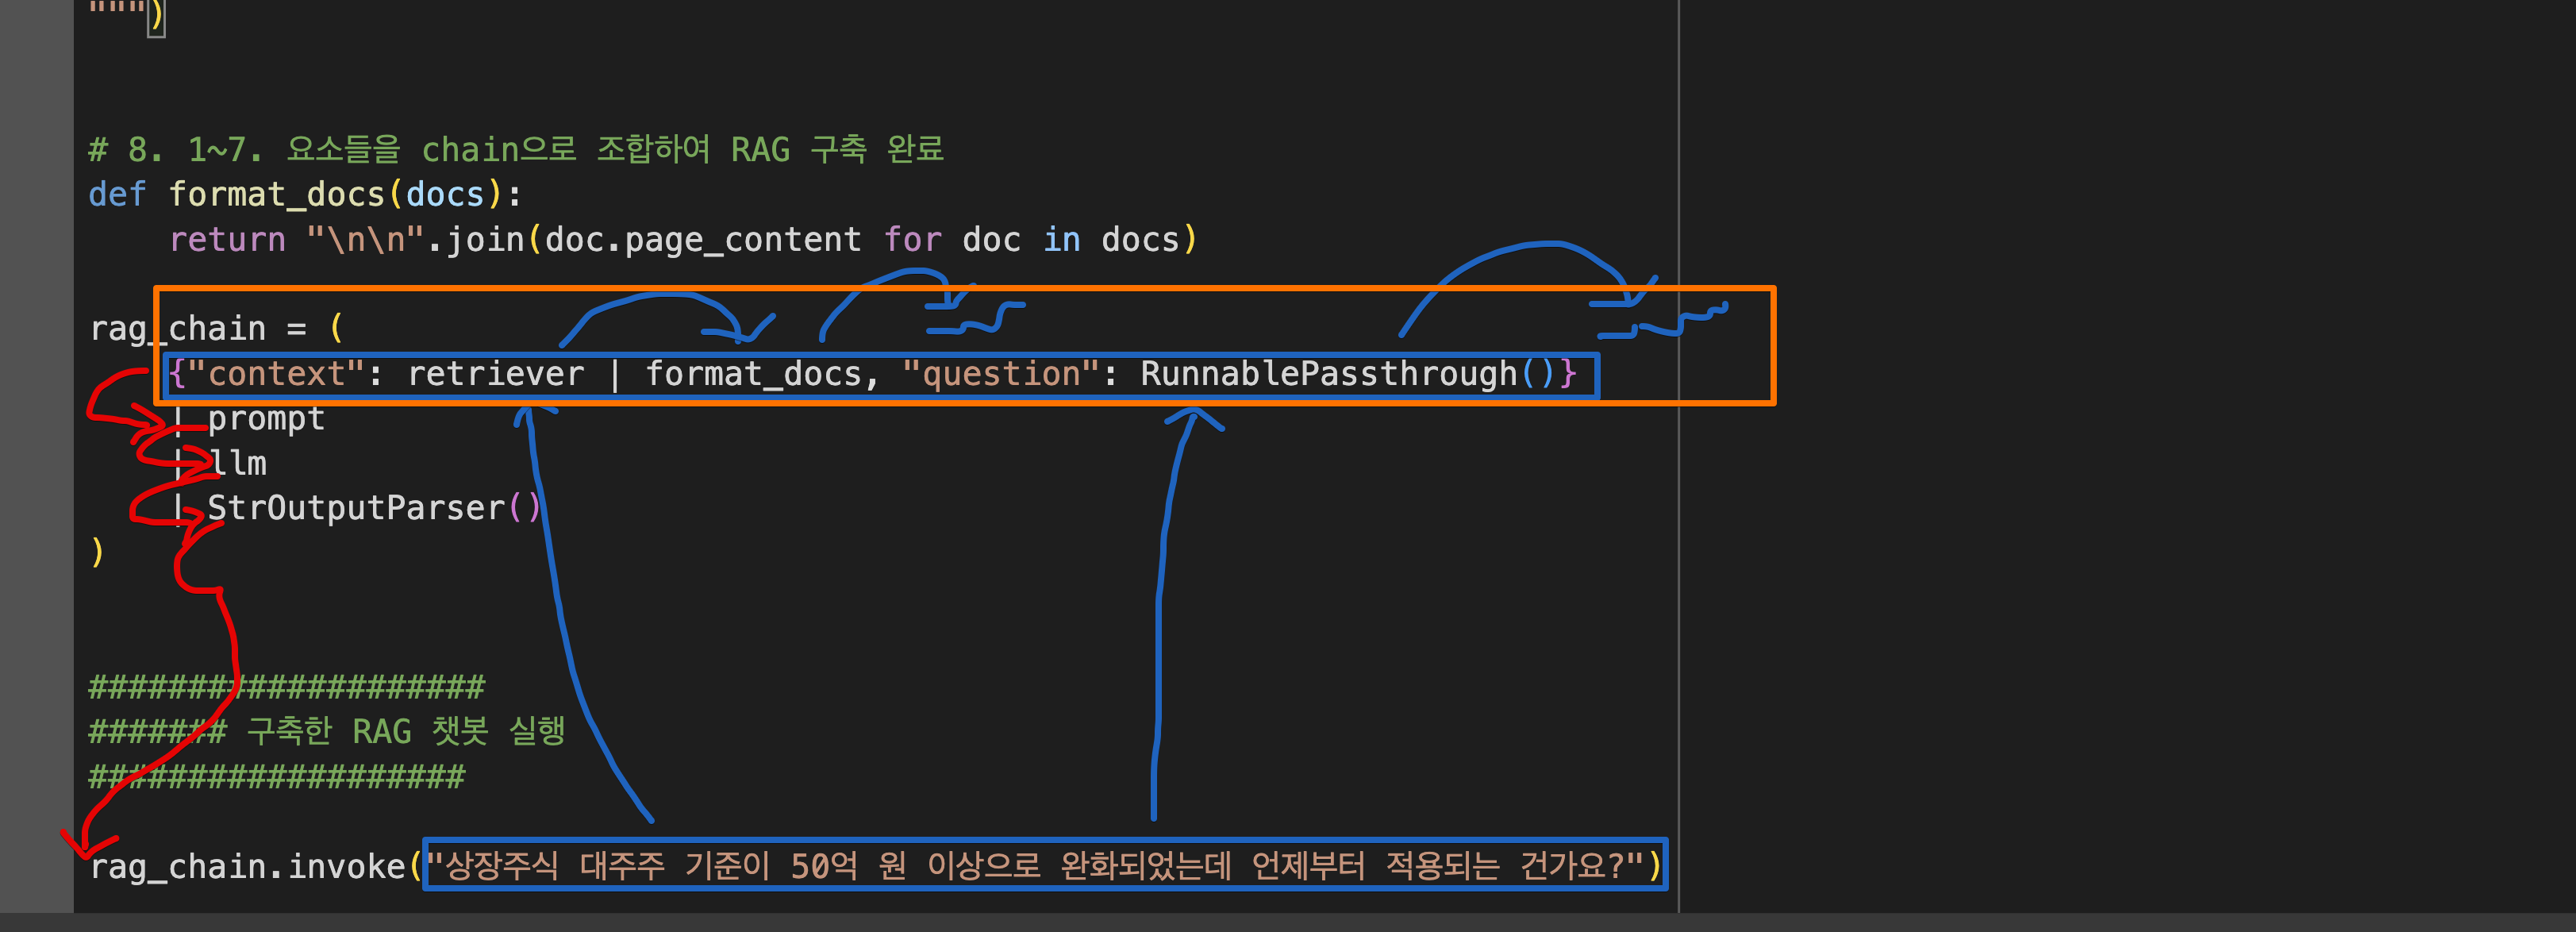

## 1. 모델 불러오기



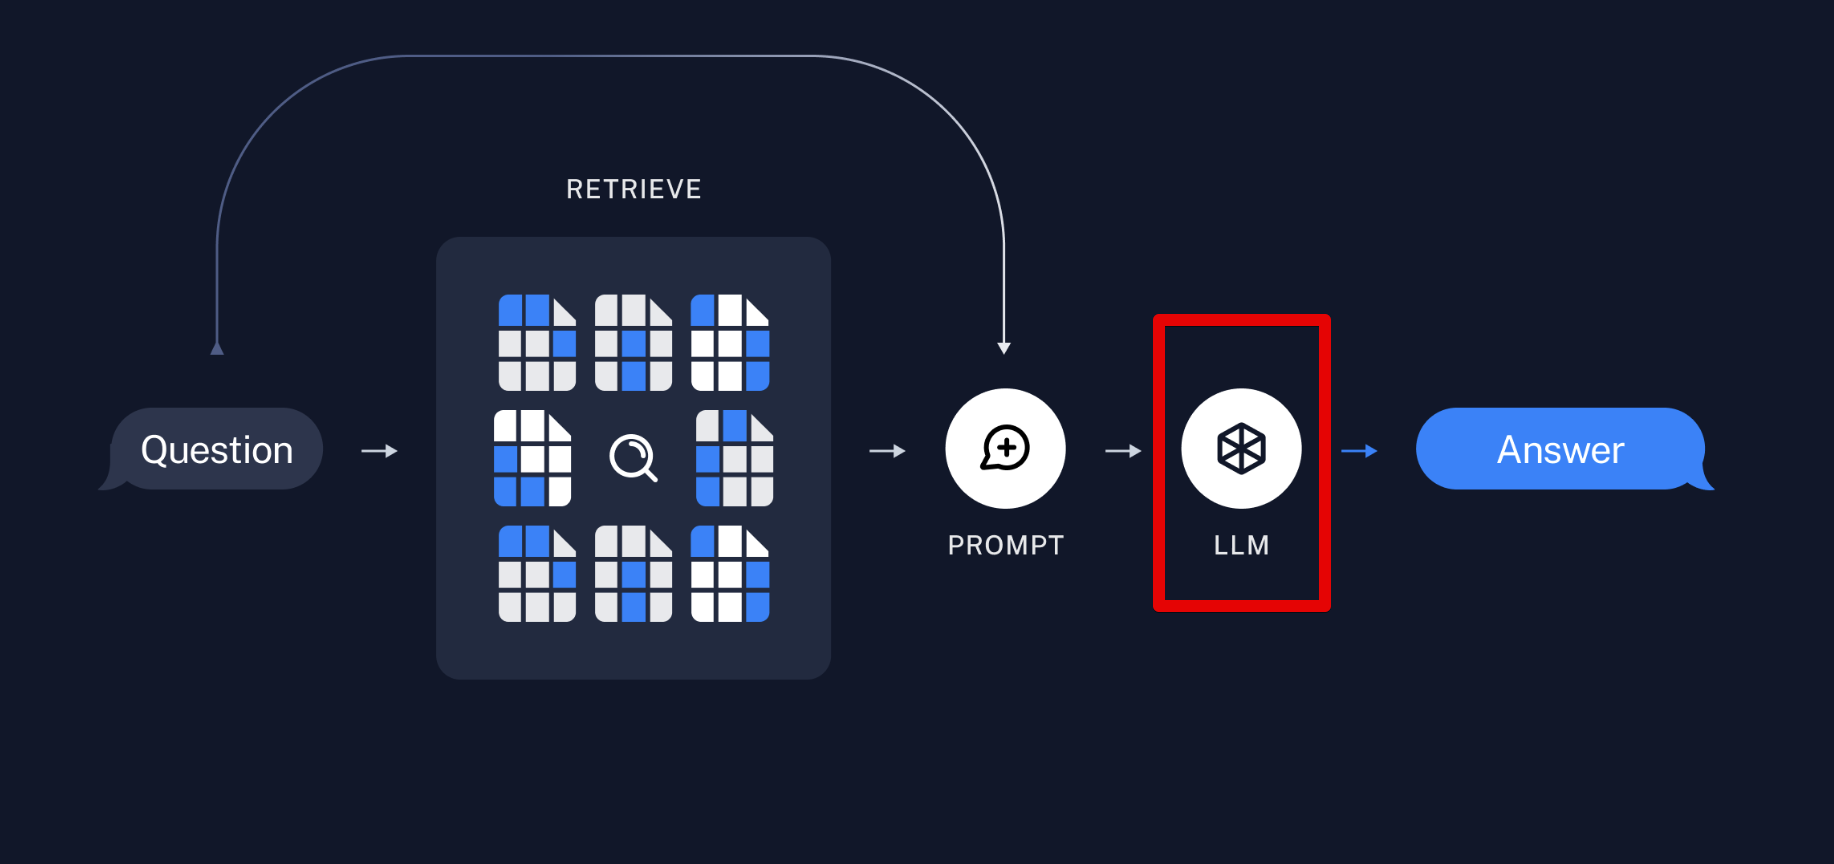

우리는 사용자가 질문한 질문인 question과 리트리버가 검색해온 검색내용인 context를 조합해서 prompt를 만들고, 이 prompt를 LLM에 넣는다고 앞에서 흐름을 확인했습니다.

그러면 이 prompt를 입력으로 받아서, 정돈된 대답으로 뱉어날 LLM 모델이 필요하겠죠?

먼저 모델을 초기화해보겠습니다!

In [ ]:
# 1. LLM 모델 불러오기
llm = ChatOpenAI(model="gpt-4o-mini")

---


# 2. 문서 불러오기

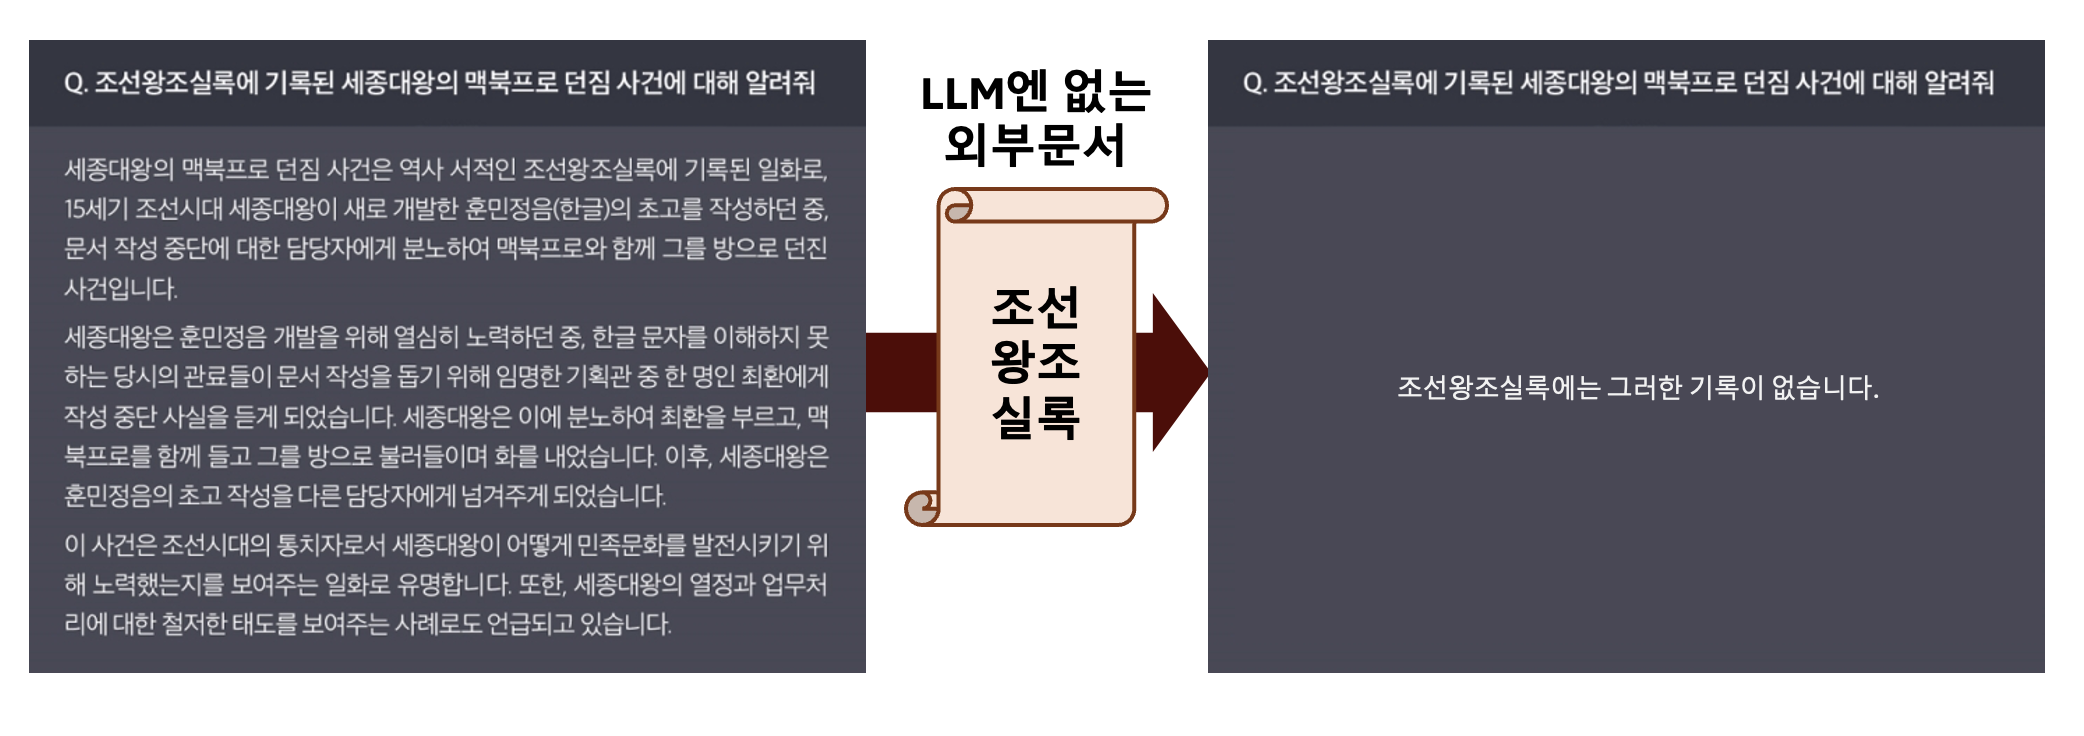

LLM의 할루시네이션(환각) 현상을 타파할 수 있는, RAG 이 참고할 문서를 이제 불러올 시간입니다.



In [ ]:
# 2. 문서 불러오기
loader = PyPDFLoader("/content/[2024 한권으로 OK 주식과 세금].pdf")
docs = loader.load()

langchain은 txt, pdf, JSON 등 다양한 문서를 불러와서 모두 `Documents` 객체로 처리합니다.

때문에 어떤 형식의 문서를 불러오더라도 하나의 통일된 양식으로 통합하여 RAG에 활용할 수 있습니다.

한번 불러온 문서를 프린트해볼까요?



In [ ]:
print(docs)

[Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 0}, page_content=''), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 1}, page_content=''), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  \n국민들의 주식시장에 대한 관심이 크게 증가하였습니다.\n최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  \n관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서  \n쉽게 찾아보기 어려운 게 현실입니다.\n이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무  \n이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.\n이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득  \n부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, \n인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주 \n발생하는 실수 사례 등을 추가하여 활용성도 강화하였습니다.\n모쪼록, 이 책자가 주식등 관련 납세자들의 성실한 납세의무 이행에 기여할 수 있기를\n기대합니다.\n2024.  5\n국세청 자산과세국장\n머리말'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 3}, page_content='본 책자에

In [ ]:
print(docs[51])

page_content='제2장 주식등 양도소득의 이해
1
40
3456789
양도소득세 과세대상 주식등의 구체적인 범위는 다음과 같습니다.
1) 상장주식등
주권상장법인의 대주주가 양도하는 상장주식 및 대주주 외의 자가 증권시장에서의 거래에 
의하지 아니하고 양도(장외거래)하는 상장주식이 과세대상에 해당합니다.
2) 비상장주식등
주권비상장법인 주식은 대주주 여부와 관계없이 모두 양도소득세 과세대상에 해당합니다.  
다만, 대주주 외의 자가 K-OTC(한국금융투자협회가 운영하는 비상장법인 주식 거래 시장)를 통해 양도하는 
중소·중견기업 주식은 과세대상에서 제외됩니다.
3) 국외주식등
외국법인이 발행한 주식등(국내증권시장에 상장된 주식은 제외) 과 내국법인이 발행한 경우로서 
해외증권시장에 상장된 주식등의 경우 과세대상에 해당합니다.
4) 신주인수권
신주인수권이란 기업의 자금조달을 용이하게 하기 위한 목적으로 주주 및 채권자 등에게 
부여한 신주를 인수할 수 있는 권리로서, 자금조달 방법에 따라 그 권리의 부여 형태가 
상이합니다.
가) 신주인수권증서
유상증자 시 다른 사람에 비해 신주를 우선적으로 인수할 수 있는 권리를 문서화한  
증서로, 기존주주*가 그 권리를 타인에게 양도 시 발행합니다.3)
* 주주는 보유주식 수에 따라 신주를 배정 받을 권리가 있음(상법 §418조①)
나) 신주인수권증권
일정한 권리행사기간에 미리 정해진 가격으로 주식을 인수할 수 있는 권리를 문서화한 
증서로, 신주인수권부사채(BW)* 발행 시 낮은 이자율을 대신하여 사채권과 별도로 
채권자에게 발행합니다.4)
* 신주인수권부사채(Bond with Warrants)：신주인수권증권이 부여된 사채로 채권과 신주인수증권의  
 분리가능 유무에 따라 분리형과 비(非)분리형으로 구분
3) 상법 §420의2
4) 상법 §516의5' metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 51}


`Documents` 객체는 `page_content`와 `meta-data`라는 두개의 딕셔너리로 이루어져있습니다.

-  `page_content` : 문서의 내용
- `meta-data` : 문서의 위치, 제목, 페이지 번호 등 문서의 메타 데이터

In [ ]:
######### CODE IT!! :: docs[51] 의 내용만 출력해보세요
print(docs[51].page_content)

제2장 주식등 양도소득의 이해
1
40
3456789
양도소득세 과세대상 주식등의 구체적인 범위는 다음과 같습니다.
1) 상장주식등
주권상장법인의 대주주가 양도하는 상장주식 및 대주주 외의 자가 증권시장에서의 거래에 
의하지 아니하고 양도(장외거래)하는 상장주식이 과세대상에 해당합니다.
2) 비상장주식등
주권비상장법인 주식은 대주주 여부와 관계없이 모두 양도소득세 과세대상에 해당합니다.  
다만, 대주주 외의 자가 K-OTC(한국금융투자협회가 운영하는 비상장법인 주식 거래 시장)를 통해 양도하는 
중소·중견기업 주식은 과세대상에서 제외됩니다.
3) 국외주식등
외국법인이 발행한 주식등(국내증권시장에 상장된 주식은 제외) 과 내국법인이 발행한 경우로서 
해외증권시장에 상장된 주식등의 경우 과세대상에 해당합니다.
4) 신주인수권
신주인수권이란 기업의 자금조달을 용이하게 하기 위한 목적으로 주주 및 채권자 등에게 
부여한 신주를 인수할 수 있는 권리로서, 자금조달 방법에 따라 그 권리의 부여 형태가 
상이합니다.
가) 신주인수권증서
유상증자 시 다른 사람에 비해 신주를 우선적으로 인수할 수 있는 권리를 문서화한  
증서로, 기존주주*가 그 권리를 타인에게 양도 시 발행합니다.3)
* 주주는 보유주식 수에 따라 신주를 배정 받을 권리가 있음(상법 §418조①)
나) 신주인수권증권
일정한 권리행사기간에 미리 정해진 가격으로 주식을 인수할 수 있는 권리를 문서화한 
증서로, 신주인수권부사채(BW)* 발행 시 낮은 이자율을 대신하여 사채권과 별도로 
채권자에게 발행합니다.4)
* 신주인수권부사채(Bond with Warrants)：신주인수권증권이 부여된 사채로 채권과 신주인수증권의  
 분리가능 유무에 따라 분리형과 비(非)분리형으로 구분
3) 상법 §420의2
4) 상법 §516의5


In [ ]:
######### CODE IT!! :: docs[51] 의 메타데이터만 출력해보세요
print(docs[51].metadata)

{'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 51}


---


## 3. 문서 chunking 하기

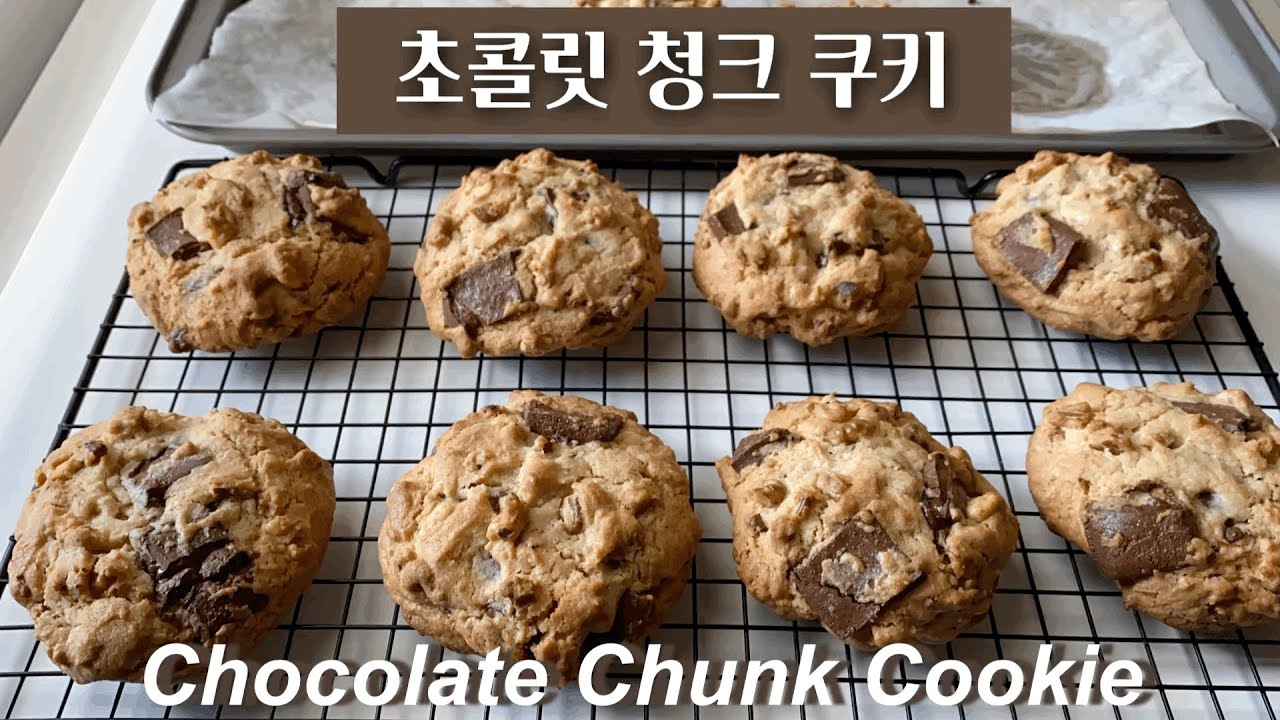

청크..! 청크는 덩어리입니다! 초콜릿이 덩어리째 들어가는 쿠키는 초콜릿 청크 쿠키🍪 (맛있겠다..)

우리는 외부에서 불러온 문서를 덩어리(chunk)들로 잘라서 나눌꺼에요! 🗡️


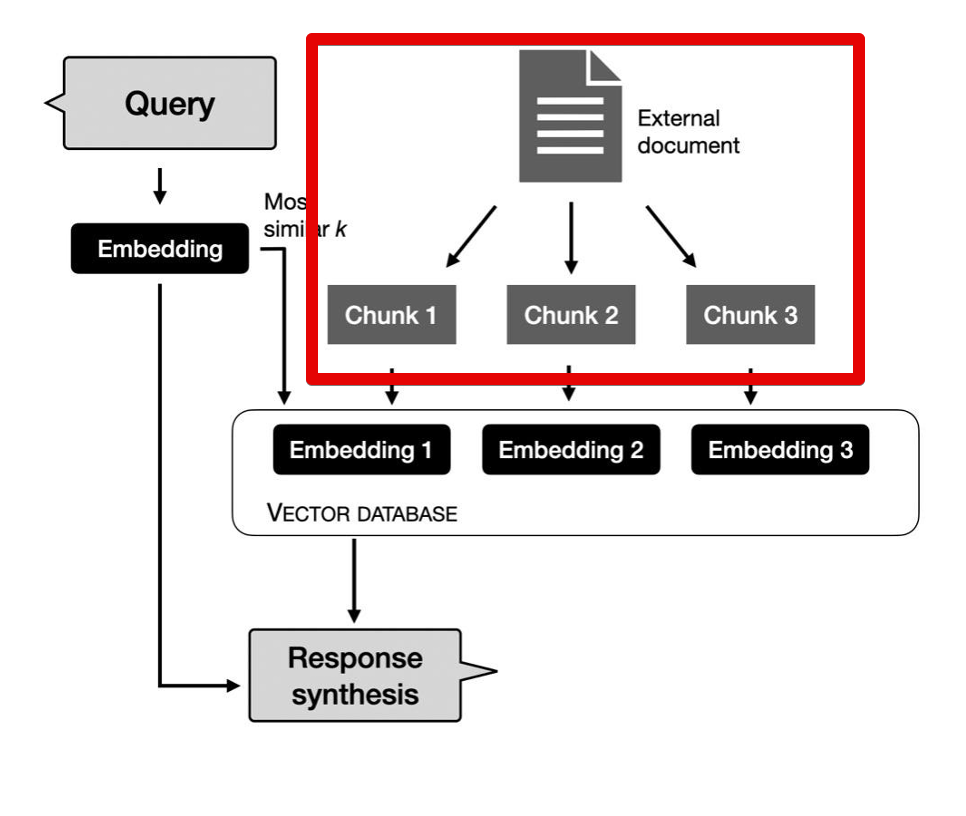

왜 외부 문서를 그대로 임베딩하면 안될까요?

(컨택스트 윈도우 = context window = 최대 입력길이. AI분야에서 window는 보통 일정크기 구간을 의미합니다.)

1. 임베딩 모델의 컨텍스트 윈도우 크기를 벗어날 수 있다.

  ex) openai text-embedding-3-large 임베딩 모델 입력가능 최대 토큰 수 : 8191K

  ex) "안녕하세요" → 2~3개의 토큰

2. LLM 모델의 컨텍스트 윈도우 크기를 벗어날 수 있다.

  ex) openai chatgpt-4o-mini의 입력가능 최대 토큰 수: 128k

  ex)  {question} = "우리 회사의 야근 식대는 얼마인가요?"

      ```
    prompt = ChatPromptTemplate.from_template("""
    오로지 아래의 context만을 기반으로 질문에 대답하세요:
    {context}
    질문:
    {question}
    """)
    ```
    {context} 에 청크 하나 인 '야근 식대는 2만원입니다.' 는 넣을 수 있지만,

    {context} 에 30MB 사규 문서 전체를 context에 넣을 순 없다.

3. 'Needle in a haystack, Lost in the middle' 문제
    LLM이 주어진 텍스트에서 특정 위치의 정보를 얼마나 정확하게 탐색하는지 테스트해보았을때,
  
    주어진 텍스트가 과도하게 길어지면 성능이 하락하는 성향이 있다.

    따라서 우리는 사용자 질문과 유사한 텍스트를 짧고 알차게 (=청크로) LLM 에 제공해줘야한다.

In [ ]:
# 3. 문서 chunking 하기
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # splitter 정의
splits = text_splitter.split_documents(docs) # splitter로 자른 chunk들

외부 문서를 덩어리(chunk)로 잘라(split)보았습니다!



In [ ]:
print(splits)
print(len(splits))
print(splits[0])

[Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 2}, page_content='지난해 말 국내 상장법인 주식을 보유한 개인 투자자가 1,400만명을 넘어서는 등  \n국민들의 주식시장에 대한 관심이 크게 증가하였습니다.\n최근 일반 국민들의 주식투자에 대한 관심이 크게 증가했음에도 불구하고, 주식 투자  \n관련 세금문제 등 궁금한 사항에 대하여 도움을 줄 수 있는 안내책자 등은 시중에서  \n쉽게 찾아보기 어려운 게 현실입니다.\n이에 국세청에서는 주식 관련 각종 세금에 대한 납세자들의 이해를 높이고 납세의무  \n이행에 도움이 될 수 있도록 「주식과 세금」 책자를 처음으로 제작·발간하게 되었습니다.\n이번에 새롭게 출간하는 ‘주식과 세금’ 책자는 주식거래의 기초상식과 주식의 취득  \n부터 보유 및 처분시까지 단계별 세금문제를 총 76개의 문답형식으로 구성하는 한편, \n인포그래픽 등을 적극 활용하여 가독성을 제고하였으며, 구체적인 절세 꿀팁 및 자주 \n발생하는 실수 사례 등을 추가하여 활용성도 강화하였습니다.\n모쪼록, 이 책자가 주식등 관련 납세자들의 성실한 납세의무 이행에 기여할 수 있기를\n기대합니다.\n2024.  5\n국세청 자산과세국장\n머리말'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 3}, page_content='본 책자에 수록된 내용은 세법에서 규정하고 있는 내용을 알기 쉽게 요약하여 서술한\n것으로 모든 법령규정을 담고 있지는 않습니다.\n또한, 법령이 개정되거나 법령의 해석이 변경되어 본 책자의 내용과 다른 경우가 발생\n할 수 있으므로 실제 사안에 적용하는 경우 반드시 관련 법령과 해석 등을 충분히 확인\n하시기 바랍니다.\n본 책자는 발간일 현재 개정된 법령 등을 기준으로 작성되었습니다. 다만, 시행

프린트해보면 langchain에서 불러온 문서와 동일하게 자른 문서도 `Documents` 객체로 관리하고 있음을 알 수 있습니다.

---

## 4. 자른 chunk들을 embedding 하기

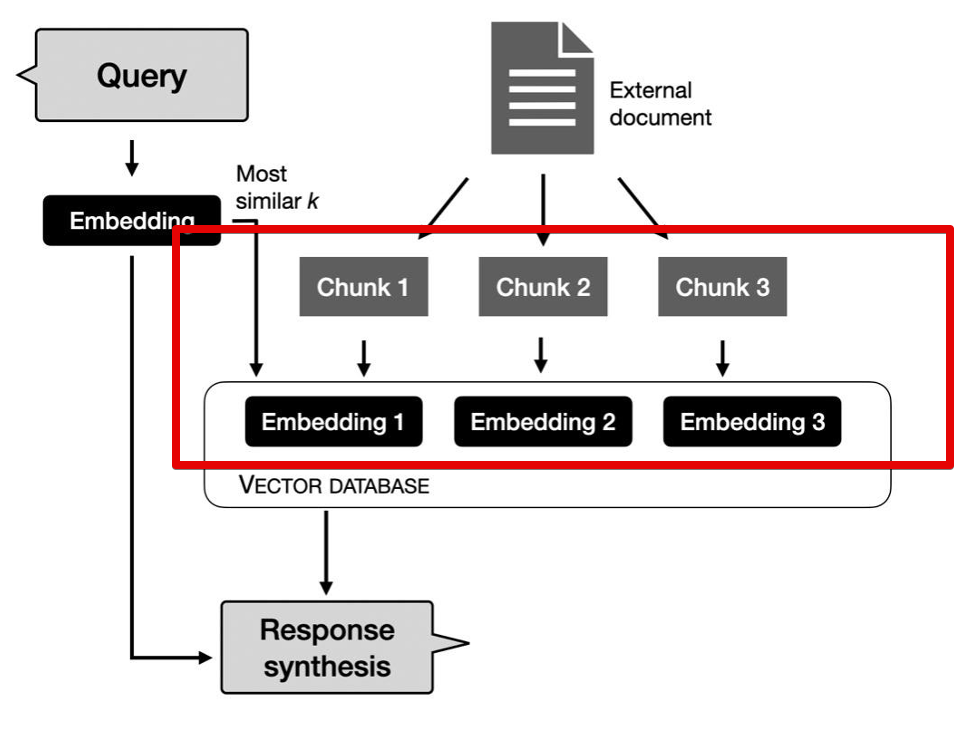


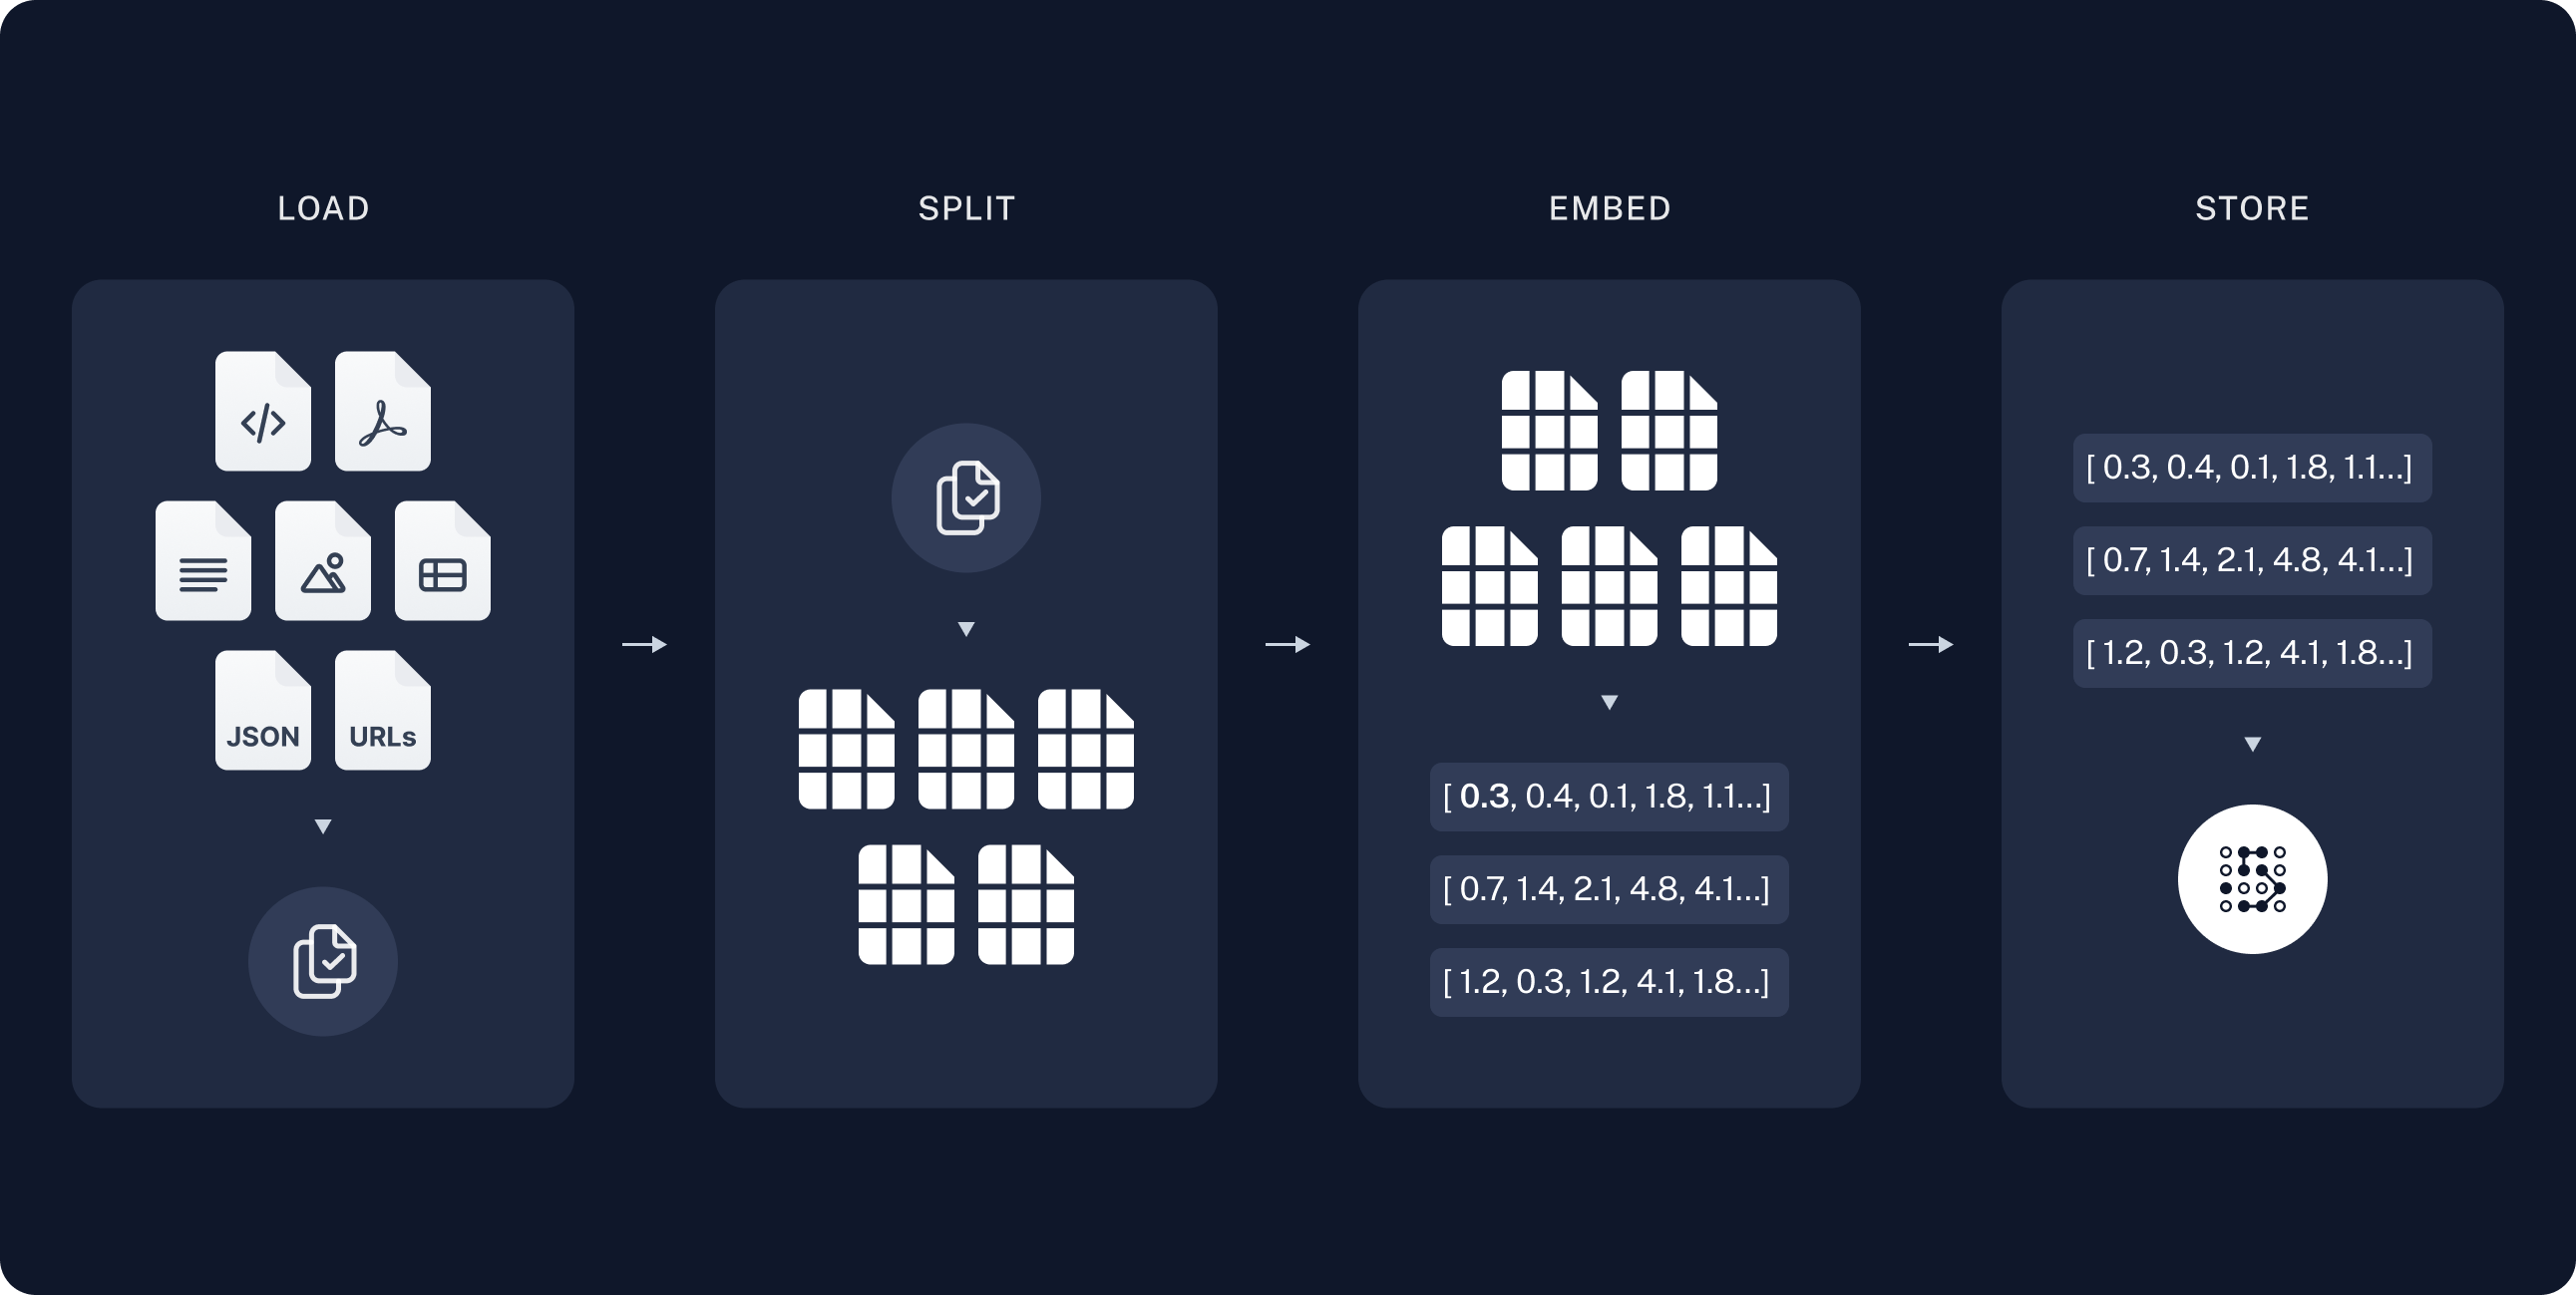

이제 자른 chunk들을 embedding 할겁니다.

- embedding: chunk를 “실수 벡터 형태”로 표현
- 왜 embedding을 하나요?
  - 컴퓨터는 청크 임베딩 간의 거리를 계산하여 이들 간의 의미적 관계를 이해할 수 있습니다.
  - 따라서 사용자가 입력한 질문(Query)에 대해 DB에 저장한 chunk를 검색해서 가져올때 유사도 계산을 기반으로 계산하기때문에 embedding하여 DB에 저장해둡니다.
  - 따라서 chunk한 결과들은 DB에 embedding하여 저장해둬야겠죠?

- 예시
  - "치타"와 "모니터"의 embedding값의 유사도 계산값 보다  
    "치타"와 의 "호랑이" embedding 값의 유사도 계산 값이 가깝습니다!
  - "치타"와 의 "호랑이"가 의미적으로 더 가깝기 때문이죠.

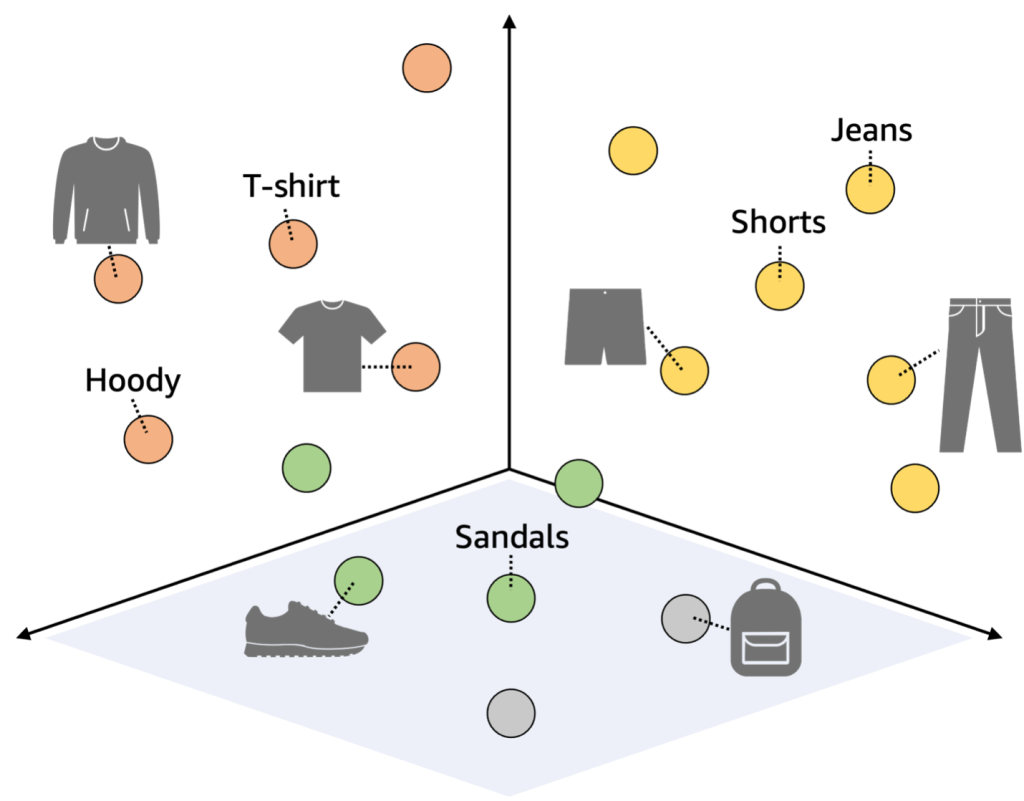

In [ ]:
########### 해당 코드는 cosine simularity 기반으로 embedding 사이의 거리를 측정하는 식을 코드화한것입니다.
########### 당장 이해하지 않고 넘어가셔도 무방합니다.
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A,B) :
  return dot(A,B)/(norm(A)*norm(B))
###########

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002") # embedding 객체 정의
embedded_example = embeddings.embed_documents( # embedding 객체를 이용하여 embedding 실행
    [
      "아 배고프다..",
      "브라키오사우루스",
      "우리 회사의 야근 식대는 2만원입니다.",
      "하하 랭체인은 재미있다!",
    ])

print(embedded_example)

[[-0.014795884490013123, -0.02590867318212986, -0.006445417646318674, -0.018948892131447792, -0.026061078533530235, 0.027788322418928146, -0.024498937651515007, 5.963202056591399e-05, -0.018148772418498993, -0.0020304652862250805, 0.012967037037014961, -0.0025384784676134586, 0.004575293976813555, -0.021844567731022835, 0.008020258508622646, -0.02203507348895073, 0.015596006065607071, 0.005692922975867987, 0.012262169271707535, -0.0365261510014534, -0.0013541727093979716, -0.005251586437225342, 0.007283639628440142, -0.011144540272653103, -0.0014073553029447794, 0.01619292050600052, 0.0024464011657983065, -0.015697607770562172, 0.011036586947739124, -0.012312970124185085, 0.03012518398463726, 0.011570001021027565, -0.0021495309192687273, -0.003451314754784107, 0.012268519029021263, -0.0013565539848059416, -0.018732987344264984, -0.018758388236165047, 0.010471422225236893, 0.006902629509568214, 0.007518595550209284, 0.00017373655282426625, -0.007575747091323137, -0.005819926504045725, 0

In [ ]:
embedded_query = embeddings.embed_query("우리 회사의 야근 식대는 얼마입니까?", )

print(embedded_query)

[0.009197620674967766, -0.02277635782957077, 0.009224832989275455, -0.03363390266895294, -0.02401449903845787, 0.007279182318598032, -0.020449740812182426, 0.005068215541541576, -0.019932715222239494, 0.01023847609758377, 0.001000037183985114, 0.017347583547234535, -0.018422454595565796, -0.030776655301451683, 0.00332495360635221, 0.023919256404042244, 0.015823718160390854, -0.03738914430141449, 0.0021412360947579145, -0.011034424416720867, 0.0036565985064953566, -0.009544572792947292, -0.021211672574281693, -0.0002742448996286839, -0.005139647051692009, 0.01687137596309185, -0.003064739750698209, -0.012565093114972115, 0.013592342846095562, 0.010333717800676823, 0.02412334643304348, -0.00780301121994853, -0.004870929289609194, 0.0015570307150483131, -0.01261951681226492, 0.012292974628508091, -0.004901542793959379, 0.016830557957291603, 0.017619702965021133, -0.006163494661450386, -0.003881096839904785, -0.000610141723882407, 0.020844312384724617, -0.008979925885796547, -0.00075895682

In [ ]:
print(cos_sim(embedded_query,embedded_example[2])) # "우리 회사의 야근 식대는 2만원입니다." <-> "우리 회사의 야근 식대는 얼마입니까?" 와의 유사도
print(cos_sim(embedded_query,embedded_example[1])) # 브라키오 사우루스 <-> "우리 회사의 야근 식대는 얼마입니까?" 와의 유사도

0.9353320259739827
0.7887244171405405


In [ ]:
# 4. 자른 chunk들을 embedding 하기
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002") # embedding 객체 정의

## 5. embedding한 chunk들을 vectore DB에 저장

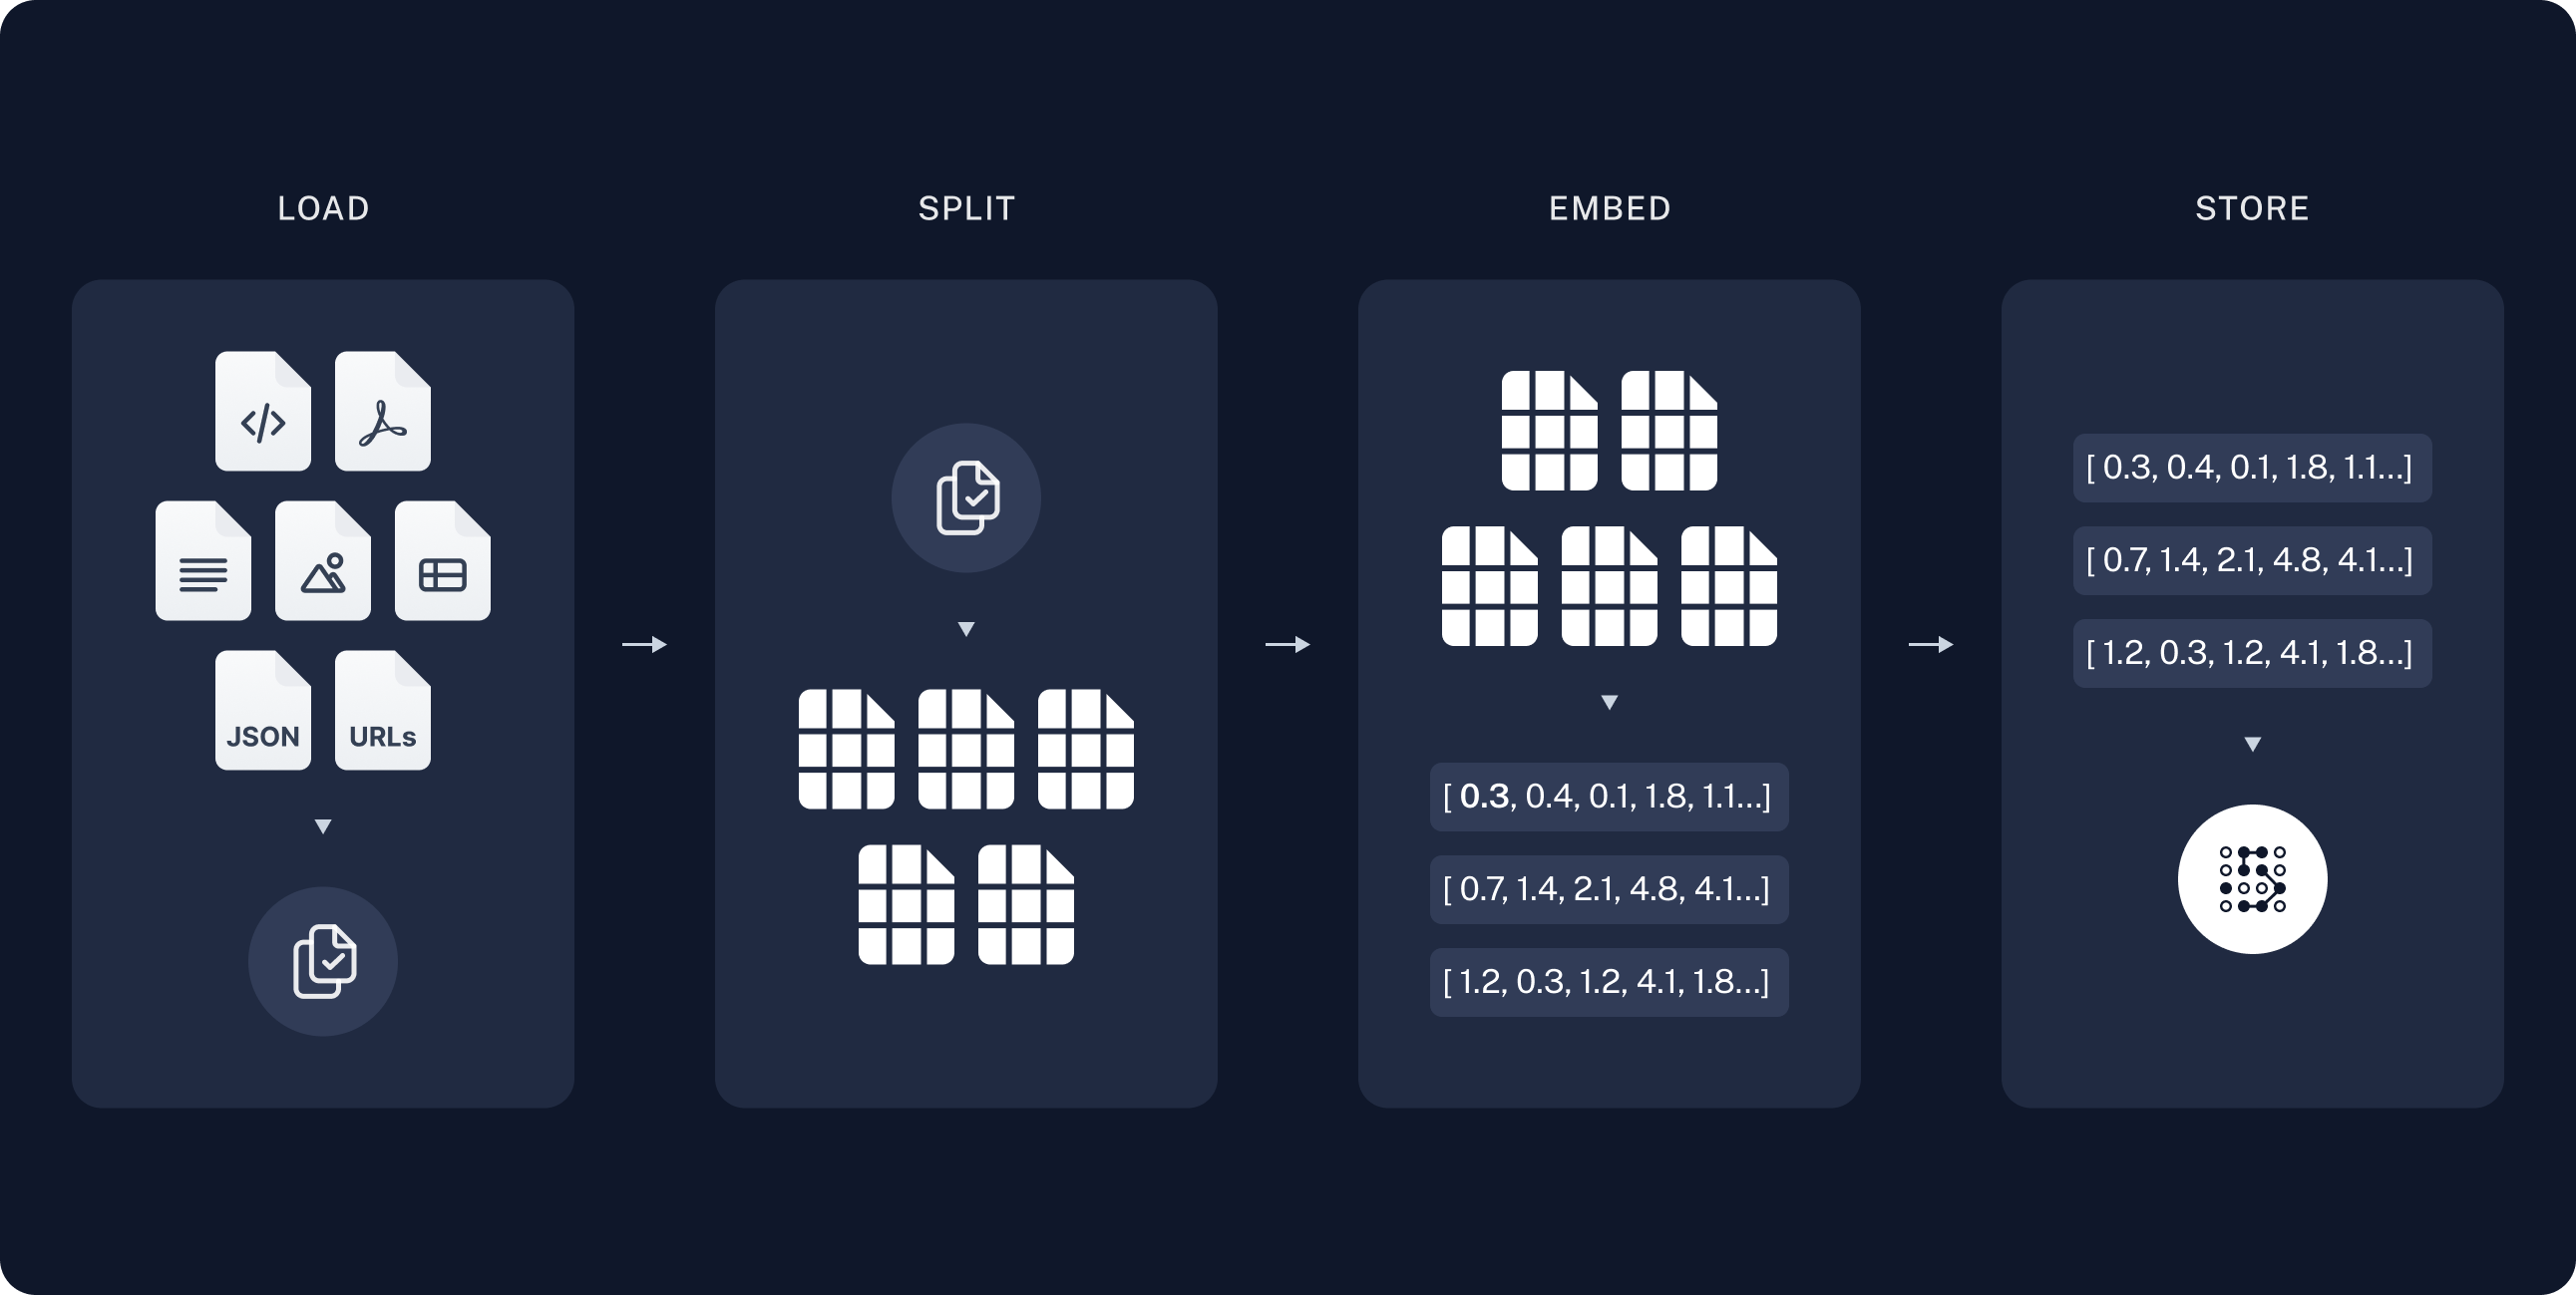

In [ ]:
# 5. vector DB 구축하기
vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings) # 위에서 잘라둔 chunk와 정의해둔 embedding을 넣어준다.

이제 위에서 잘라둔 chunk와 정의해두 embedding을 넣어줘서 vector DB를 구축할겁니다.

vector DB는 기존의 전통적인 관계형 DB와 아래의 차이점이 있습니다.

1. 비정형 데이터를 저장하는데 특화됨

  - vector DB : 오디오, 텍스트, 비디오 모두 함께 embedding 형태로 저장 가능

  - 관계형 DB : 보통 텍스트 정보를 열과 행의 테이블 형태로 적재

2. 데이터 조회 방식이 다름
  - vector DB : 유사도 기반 검색 -> '비슷한 것' 찾기
  - 관계형 DB : 행과 열을 추출 -> '정확한 것' 찾기


vector DB로는 순수 vector DB인 Chroma, Weaviate, Qdrant, Pinecone 등이 있고,

vector library인 FAISS, Annoy, Hnswlib 등이 있고,

기존의 SQL DB, noSQL DB도 최근 조금씩 유사도 계산 같은 벡터 전용 기능이 추가되기 시작하고 있습니다.


---

## 6. retriever 구축하기

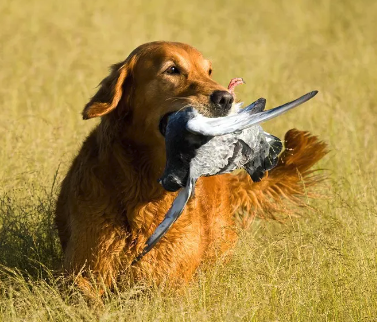

- 리트리버 : 물어오기! 저장된 벡터 데이터베이스에서 사용자의 질문과 관련된 문서를 검색(물어오기)하는 검색기

- 동작방식
  1. 질문의 vector embedding: 사용자의 질문을 벡터 형태로 변환합니다.
  
    `Q. 우리 회사의 사내 밥 시간 규정은 어떻게 돼? ---변환---> ['0.0038338393383393', '38383727829', .., '0.338292728']`

  2. vector 유사성 비교: 저장된 문서 벡터들과 질문 벡터 사이의 유사성을 계산합니다. 주로 벡터 간 코사인 유사도를 사용합니다.

      `['0.289478233', '3387497263874829', .., '0.87598742'] <---유사도 계산---> ['0.0038338393383393', '38383727829', .., '0.338292728']`

      `['0.5893475983749', '4859387495', .., '0.09804975983'] <---유사도 계산---> ['0.0038338393383393', '38383727829', .., '0.338292728']`
      
      ...


  3. 상위 문서 선정: 계산된 유사도 점수를 기준으로 상위 N개의 가장 관련성 높은 문서를 선정합니다. 보통 top-k 라는 파라미터를 사용합니다. 이 top-k개의 문서들은 다음 단계에서 사용자의 질문에 대한 답변을 생성하는 데 사용됩니다.

    `top 2개의 문서는 아래와 같습니다!`

    `사칙 3873조. 우리 회사의 점심 시간은 12:30 ~ 1:30 입니다.`

    `사칙 96887858483조. 우리 회사의 석식 시간은 18:00 ~ 19:00 입니다.`


  4. 문서 정보 반환: 선정된 top-k개의 문서들은 다음 단계(프롬프트 생성)로 전달합니다.

    ```
    prompt
    system: 아래 내용을 기반으로만 대답해줘.
    맥락: 사칙 3873조. 우리 회사의 점심 시간은 12:30 ~ 1:30 입니다.
    사칙 96887858483조. 우리 회사의 석식 시간은 18:00 ~ 19:00 입니다.
    질문 : 우리 회사의 사내 밥 시간 규정은 어떻게 돼?
    ```
    

In [ ]:
# 6. retriever 구축하기
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10}) # 위에서 구축한 vectorDB를 기반으로 retriever를 구축한다

---

## 7. 프롬프트 템플릿 구축하기

In [ ]:
# 7. 프롬프트 템플릿 구축하기
prompt = prompt = ChatPromptTemplate.from_template("""
너는 question-answer 테스크를 맡은 훌륭한 assistant야.
아래의 retrieved context를 이용해서 question에 답변해.
만약 답변을 모른다면, 모른다고 답변해.
context :
{context}
question:
{question}
""")

이제 모든 RAG 요소들을 만들었습니다👏👏👏

이제 요소들을 chain으로 조합해서, 순차적으로 실행되도록 만들러 가볼까요?

---

## 8. 1~7. 요소들을 chain으로 조합하여 RAG 구축 완료

In [ ]:
# 8. 1~7. 요소들을 chain으로 조합하여 RAG 구축 완료
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print(rag_chain.invoke("시간외바스켓매매가 뭐야?"))

rag_chain이 invoke로 실행되자, 첫번째 컴포넌트인

```
 {"context": retriever | format_docs, "question": RunnablePassthrough()}
```
가 먼저 실행됩니다.




이 컴포넌트는 보면 딕셔너리 형태이죠?

\

`"context"` 가 key이고 value가 `retriever | format_docs` ,

`"question"` 가 key이고 value가 `RunnablePassthrough()`인  딕셔너리입니다.


\

즉 이 컴포넌트가 실행되면 "context" key에 대응되는 value값으로는

  `retriever | format_docs` 의 실행값이 저장될 것입니다.

  \

`"question"` key에 대응되는 value 값으로

 `RunnablePassthrough()`의 실행값이 저장될 것입니다.

\


### "context" 에선 무슨일이?


```
 {"context": retriever | format_docs, "question": RunnablePassthrough()}
```




이제 첫번째 컴포넌트의 형태를 파악했으니, 다시 처음으로 돌아와서 상황을 파악해보겠습니다.

rag chain을 `rag_chain.invoke("시간외바스켓매매가 뭐야?")` 으로 `invoke(깨움)` 시키는 순간 질문인  "시간외바스켓매매가 뭐야?" 가 체인의 첫 컴포넌트로 전달됩니다.

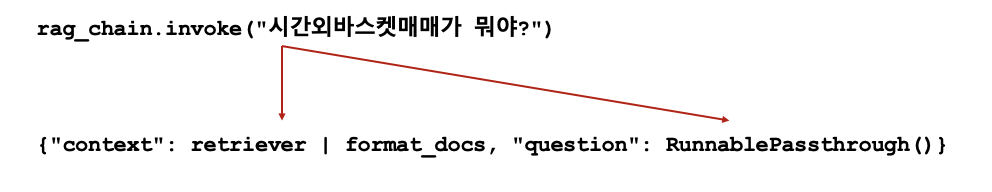


그러면 위에서 말했던것처럼 "context"와 "question"은 서로 다른 key 이니까 일단 "context" 부터 볼까요?

`"시간외바스켓매매가 뭐야?"` 라는 질문이 우리가 앞서 정의해둔 `retriever`로 전달됩니다.

\


> **langchain에서 retriever에 문자열(보통 질문을 넣겠죠)이 전달되면, retriever는 그와 가장 유사한 문서들을 return 합니다.**

\

따라서 아래와 같이 검색된 문서들을 format_docs로 넘겨주게됩니다.

그런데 문제는 Documents 객체 형태로 넘겨주게 되는게 문제입니다.





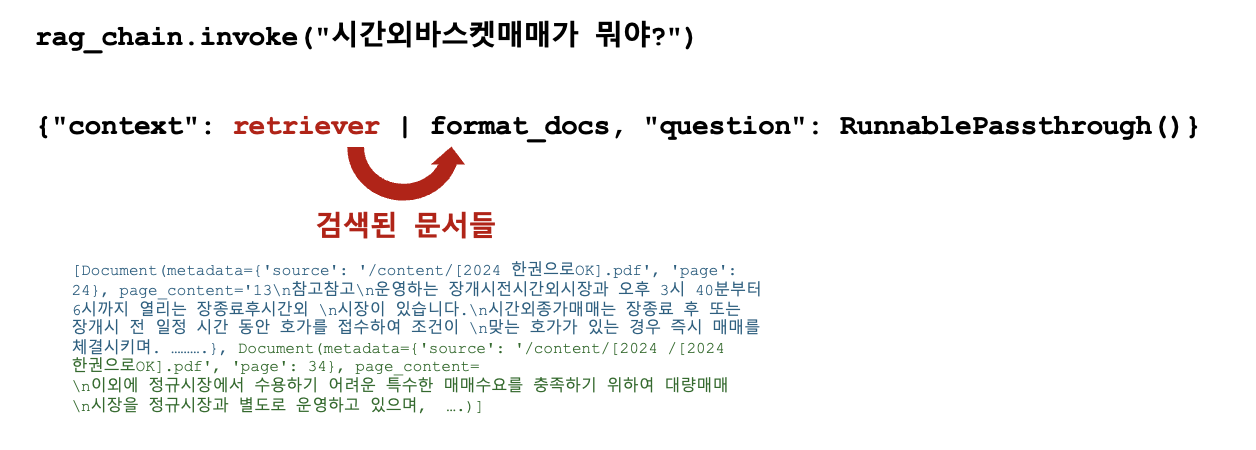

아주 못생겼어요. 이런 metadata= ... , page=24, .... 이런 쓸모없는 데이터까지 프롬프트에 넣어주면 LLM은 더 헷갈릴게 분명합니다.

\

그래서 `format_docs` 함수를 거쳐서 우리는 검색한 문장만 깔끔하게 잘 넣어주고자 합니다.



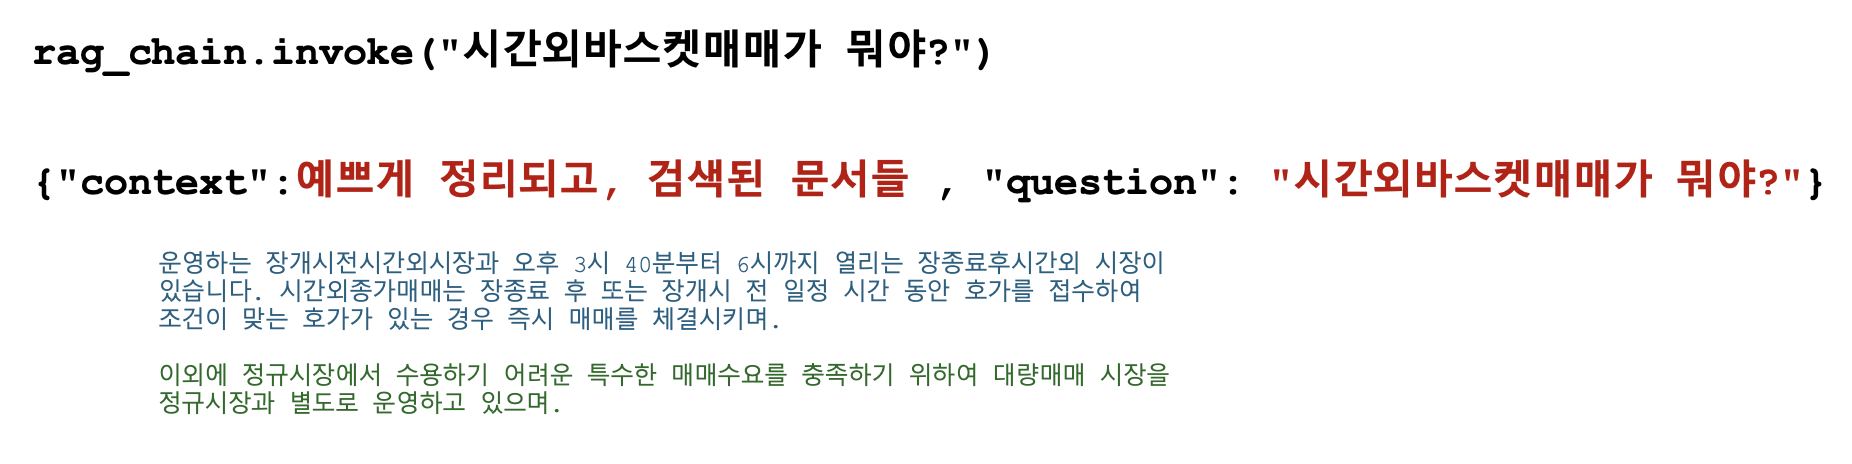

그럼 이제 첫번째 컴포넌트가 완성되었으니까, 체인의 다음으로 넘겨줄 준비가 되었습니다!

다음체인에 실행 완료된 `
 {"context": retriever | format_docs, "question": RunnablePassthrough()}
` 를 넘겨주겠습니다.

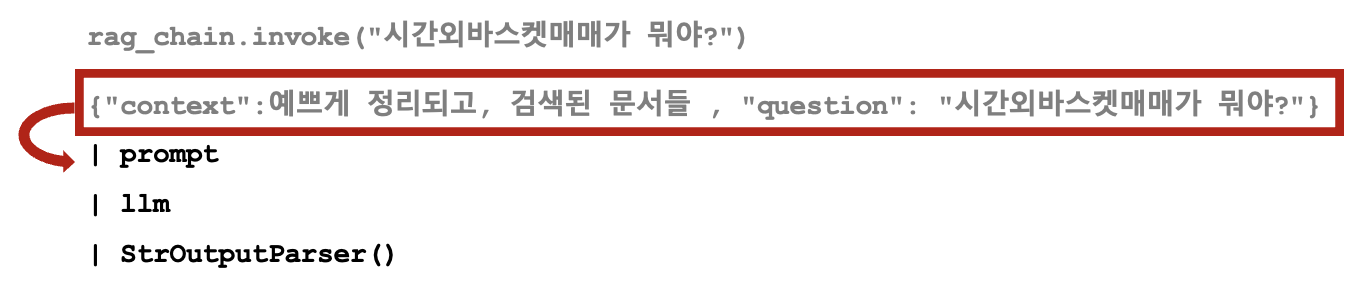

다음 채인 요소는 prompt입니다.

> **ChatPrmoptTemplate들로 정의한 프롬프트 템플릿에 intput으로 formatting할 대상을 넣으면, output으로 formatting이 완료된 프롬프트가 리턴됩니다. .**


아래의 formatting 과정을 보는게 더 이해에 도움이 될 것 같습니다.


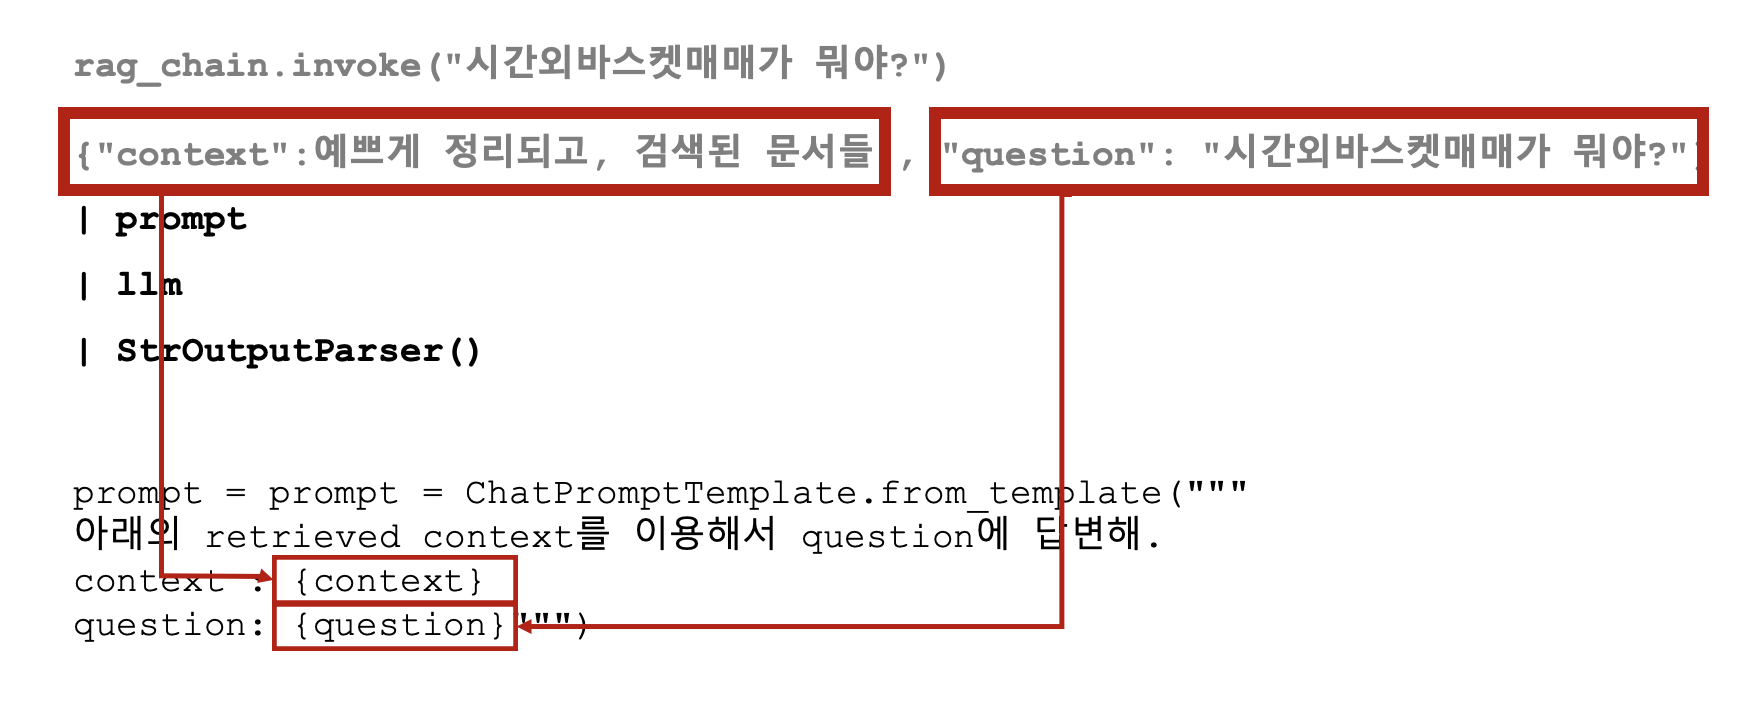

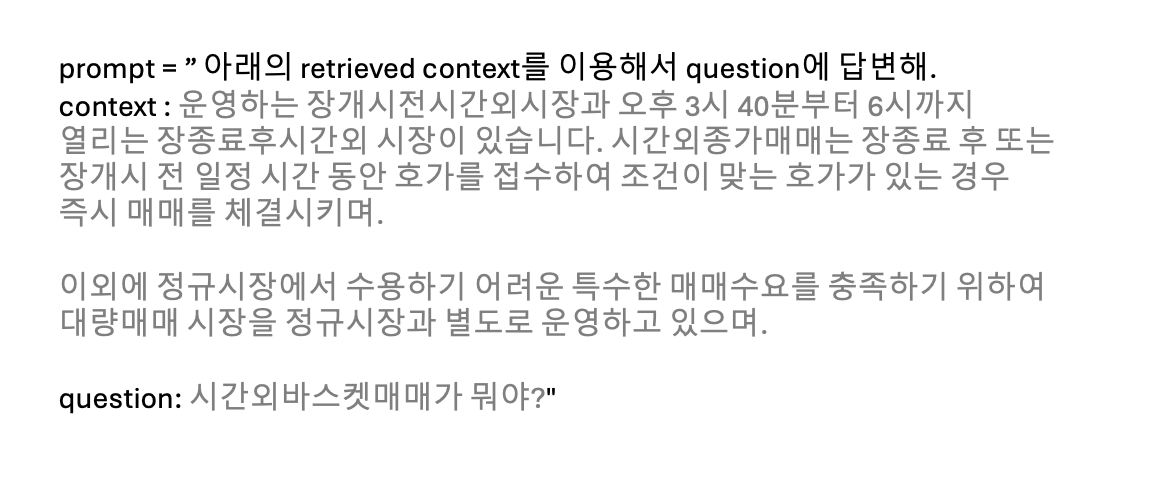

그러면 이렇게 우리는 이렇게 프롬프트 formatting을 완료하면서 이번 체인 요소를 끝내게 됩니다!

formatting이 완료되면, 완성된 프롬프트를 리턴합니다.

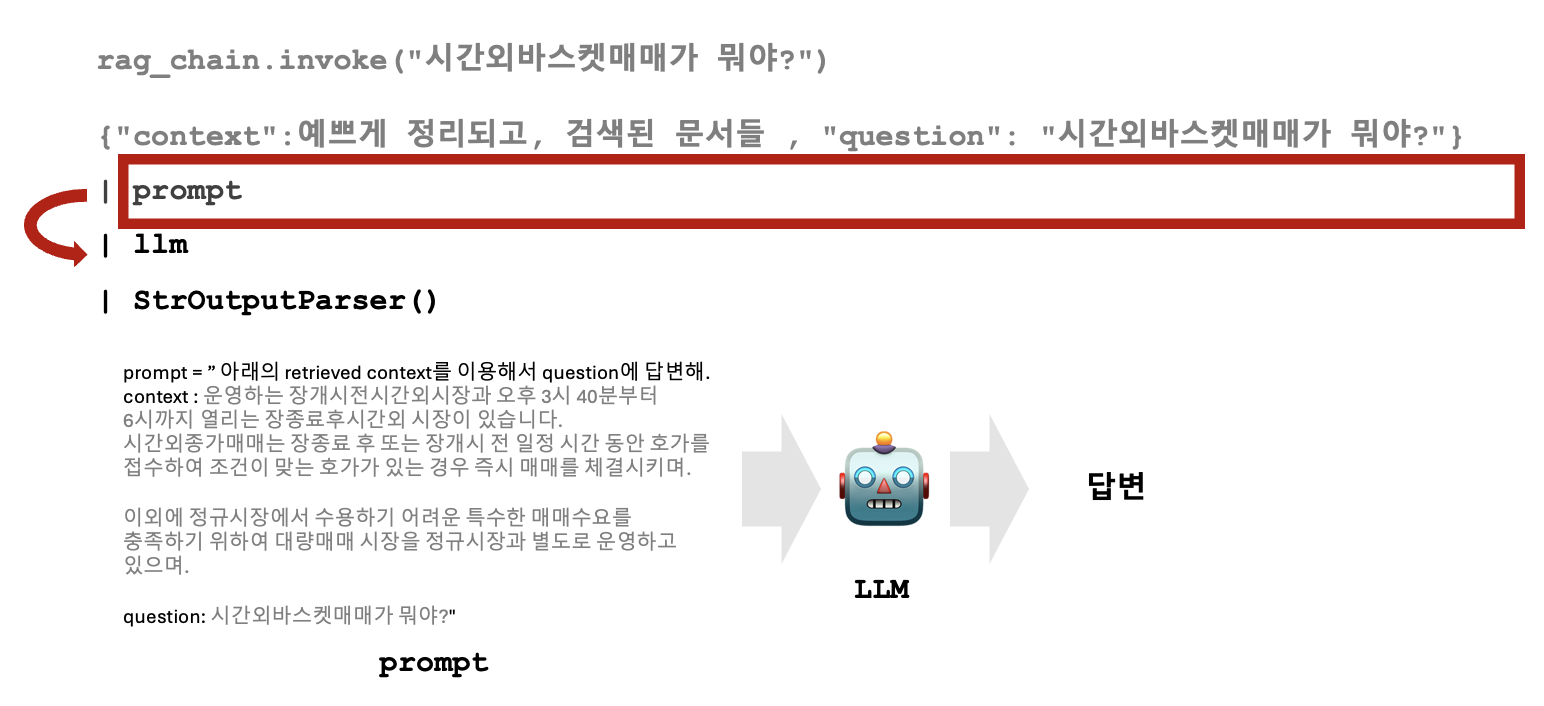

그러면 prompt는 llm에 프롬프트를 넘겨주게 되고,

llm은 프롬프트를 넘겨받아 답변을 만들게 될것입니다.

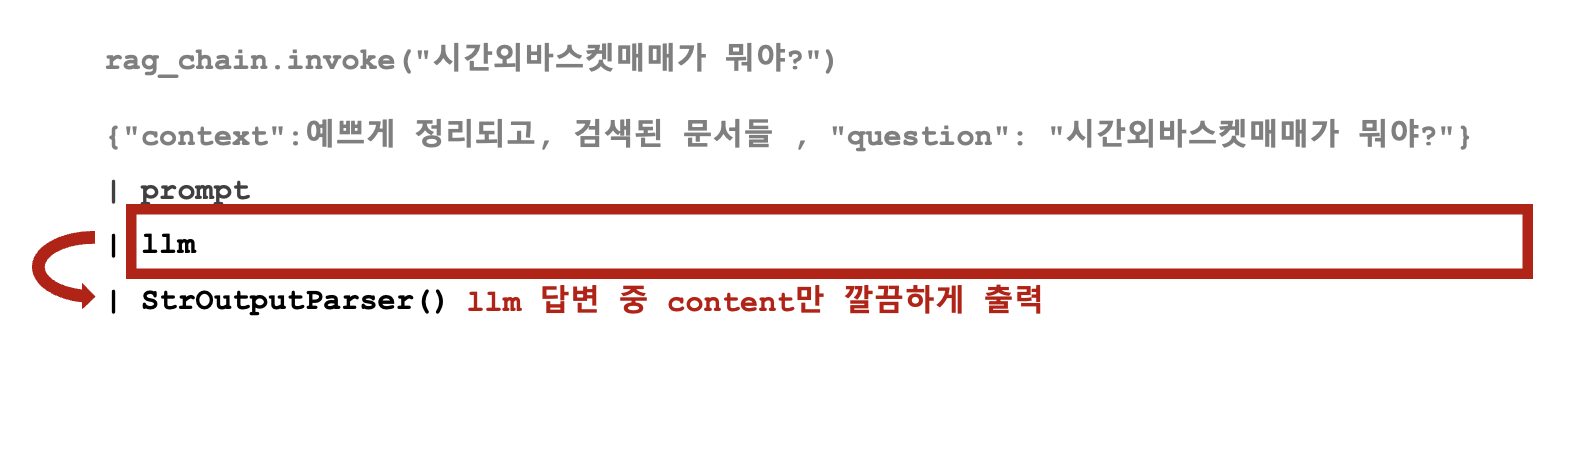

마무리로, `StrOutputParser`로 깔끔하게 llm 의 답변을 출력하면 chain이 끝납니다!!


모두 chain의 흐름을 따라오신다고 고생많으셨습니다. 😄👍👍



## 💡 실습 : 과정중간중간을 출력해보기

과정 중간중간을 DebugPassThrough() 로 출력해보세요.

In [ ]:
'''
RunnablePassthrough를 상속받은 DebugPassThrough 클래스
LangChain에서 RunnablePassthrough가 기본적으로 "데이터를 그대로 전달"하는 역할
잘 전달하는지 출력하기 위해 만들어진 커스텀 츨래스입니다.
'''
class DebugPassThrough(RunnablePassthrough):
    def invoke(self, *args, **kwargs):
        output = super().invoke(*args, **kwargs) # 부모 클래스의 invoke 호출. 부모클래스의 invoke는 그냥 전달받은걸 그대로 전달한다.
        print("Debug Output:", output)
        print()
        print()
        return output

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | DebugPassThrough() | format_docs , "question": RunnablePassthrough()} # format_docs 실행 전을 출력
    | prompt
    | llm
    | StrOutputParser()
)

print(rag_chain.invoke("시간외바스켓매매가 뭐야?"))

Debug Output: 시간외바스켓매매가 뭐야?


Debug Output: [Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 24}, page_content='13\n참고참고\n운영하는 장개시전시간외시장과 오후 3시 40분부터 6시까지 열리는 장종료후시간외 \n시장이 있습니다.\n시간외종가매매는 장종료 후 또는 장개시 전 일정 시간 동안 호가를 접수하여 조건이  \n맞는 호가가 있는 경우 즉시 매매를 체결시키며, 시간외단일가매매는 장종료 후 10분  \n단위로 단일가격에 의한 개별경쟁매매 방식으로 거래를 체결시킵니다.\n이외에 정규시장에서 수용하기 어려운 특수한 매매수요를 충족하기 위하여 대량매매 \n시장을 정규시장과 별도로 운영하고 있으며, 대량매매시장에는 시간외대량매매와 장중 \n대량(바스켓)매매가 있습니다.\n상장주식 매매거래 시간 및 호가접수시간\n구분구분 매매거래 시간매매거래 시간 호가접수시간호가접수시간\n정규시장\n시간외시장\n장 개시 전\n장 개시 후\n09:00 ~ 15:30 08:30 ~ 15:30\n08:00 ~ 09:00* 08:00 ~ 09:00\n15:40 ~ 18:00 15:30 ~ 18:00\n* 단, 장 개시 전 종가매매는 08:30 ~ 08:40 (10분)'), Document(metadata={'source': '/content/[2024 한권으로 OK 주식과 세금].pdf', 'page': 34}, page_content='23\n2) 시간외단일가매매\n시간외단일가매매는 투자자에게 추가적인 매매거래기회를 제공하기 위하여 장 종료 후  \n일정시간동안 10분 단위 단일가매매를 통하여 당일종가 ±10% 이내(다만, 당일 상·하한가 이내)의 \n가격으로 매매거래를 성립시키는 제도입니다.\n시간외단일가매매의 주요내용은 다음과 같습니다.\n3) 시간외대량매매\n시간외대량매매는 시간외시장의 매매거래 시간